In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/labels.txt
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/265708769.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/853493510.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/180748518.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/121055828.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/722443276.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/726536869.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/257586962.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/928373399.png
/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/surprise/611883075.png
/kaggle/input/facial-expres

In [10]:
pip install numpy matplotlib 


Note: you may need to restart the kernel to use updated packages.


In [11]:
import tensorflow as tf
import tensorboard
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import random
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical

RANDOM_SEED = 123


In [12]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Labels in the dataset:
surprise
fear
neutral
sadness
disgust
happiness
anger


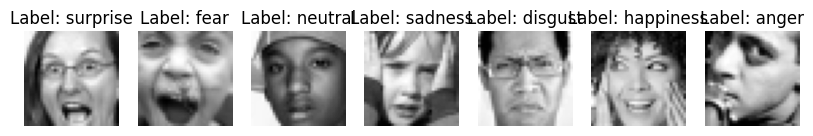

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_data(dir_path, img_size):
    labels = {}
    data = []
    labels_list = []
    class_count = 0

    # Iterate over directory
    for i, path in enumerate(os.listdir(dir_path)):
        if not path.startswith('.'):  # Ignore hidden files/folders
            class_path = os.path.join(dir_path, path)  # Use os.path.join for correct path
            labels[i] = path
            for file in os.listdir(class_path):
                if not file.startswith('.'):
                    img_path = os.path.join(class_path, file)  # Use os.path.join for correct path
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                    if img is None:
                        print(f"Warning: Could not load image at {img_path}. It may be corrupt or the path may be incorrect.")
                        continue
                    img = cv2.resize(img, img_size)  # Resize the image to the specified IMG_SIZE
                    data.append(img)
                    labels_list.append(class_count)
            class_count += 1

    data = np.array(data, dtype='float32') / 255.0  # Normalize the data
    labels_list = np.array(labels_list)
    return data, labels_list, labels

def display_labels(labels):
    print("Labels in the dataset:")
    for label in labels.values():
        print(label)

def display_sample_images(images, labels, labels_dict, num_images=5):
    # We'll try to show at least one image per label, up to num_images
    unique_labels = np.unique(labels)
    plt.figure(figsize=(10, 2))
    count = 0
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        if indices.size > 0:
            ax = plt.subplot(1, num_images, count + 1)
            plt.imshow(images[indices[0]], cmap='gray')
            plt.title(f"Label: {labels_dict[label]}")
            plt.axis('off')
            count += 1
        if count >= num_images:
            break
    plt.show()

# Example usage
TRAIN_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train/'
TEST_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/'
IMG_SIZE = (35, 35)  # Correctly define IMG_SIZE as a tuple

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

# Print all labels
display_labels(train_labels)

# Display some sample images from the train set
display_sample_images(X_train, y_train, train_labels, num_images=7)  # Display up to 7 images, showing different labels


In [14]:
X_train

array([[[0.6431373 , 0.64705884, 0.627451  , ..., 0.13333334,
         0.15294118, 0.29411766],
        [0.64705884, 0.64705884, 0.6392157 , ..., 0.13725491,
         0.12941177, 0.1764706 ],
        [0.64705884, 0.64705884, 0.6392157 , ..., 0.10980392,
         0.10196079, 0.11764706],
        ...,
        [0.16078432, 0.12941177, 0.12156863, ..., 0.36078432,
         0.12941177, 0.03529412],
        [0.17254902, 0.14509805, 0.16862746, ..., 0.3372549 ,
         0.15294118, 0.03137255],
        [0.1764706 , 0.14901961, 0.18431373, ..., 0.34509805,
         0.18431373, 0.08627451]],

       [[0.99215686, 0.96862745, 0.9529412 , ..., 0.99607843,
         0.99607843, 0.99607843],
        [0.8901961 , 0.6862745 , 0.53333336, ..., 0.99607843,
         0.99607843, 0.99607843],
        [0.5882353 , 0.3764706 , 0.2509804 , ..., 0.99607843,
         0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843, ..., 0.88235295,
         0.91764706, 0.92941177],
        [0.9

In [15]:
y_train

array([0, 0, 0, ..., 6, 6, 6])

In [16]:
train_labels

{0: 'surprise',
 1: 'fear',
 2: 'neutral',
 3: 'sadness',
 4: 'disgust',
 5: 'happiness',
 6: 'anger'}

In [17]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()


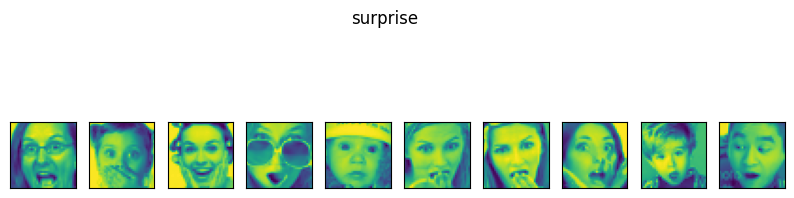

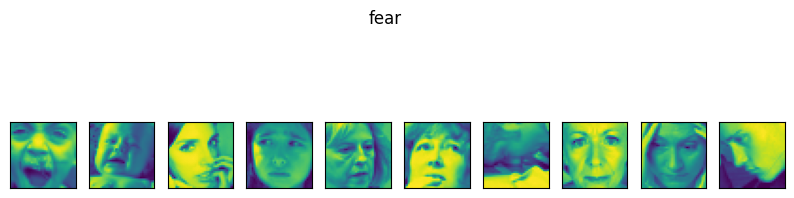

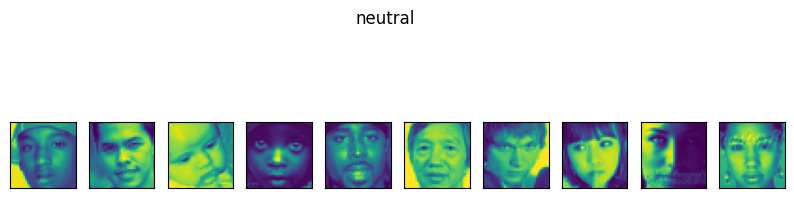

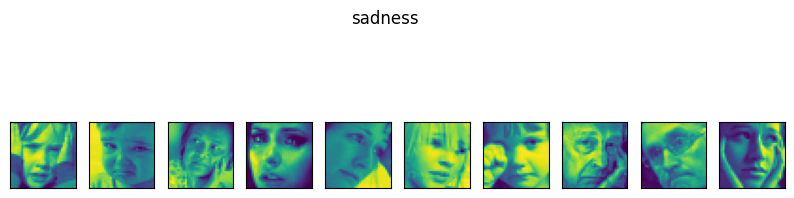

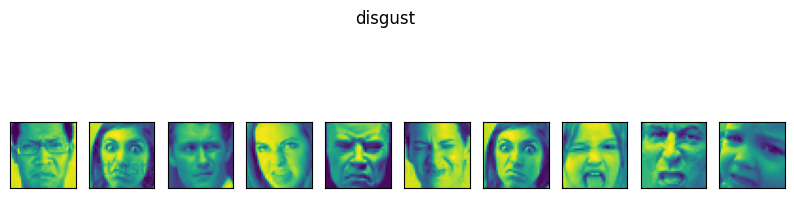

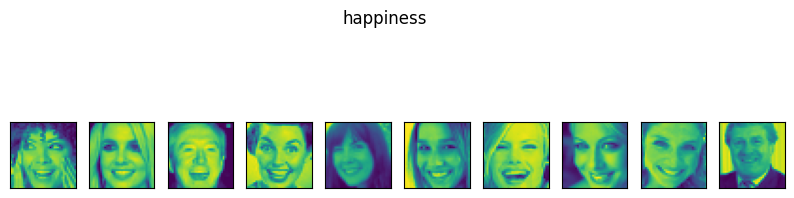

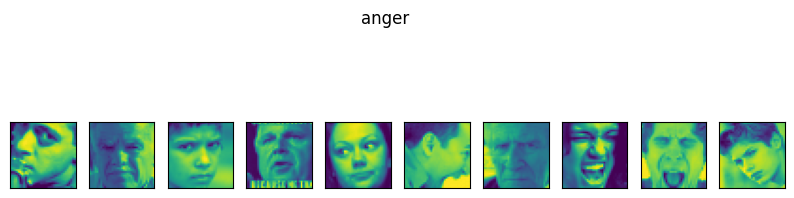

In [18]:
plot_samples(X_train, y_train, train_labels, 10)

Labels in the dataset:
surprise
fear
neutral
sadness
disgust
happiness
anger


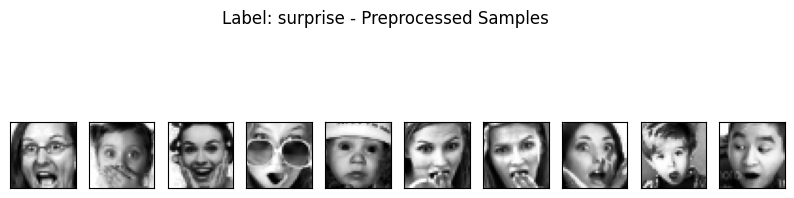

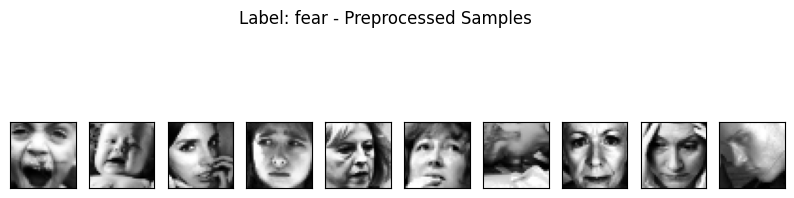

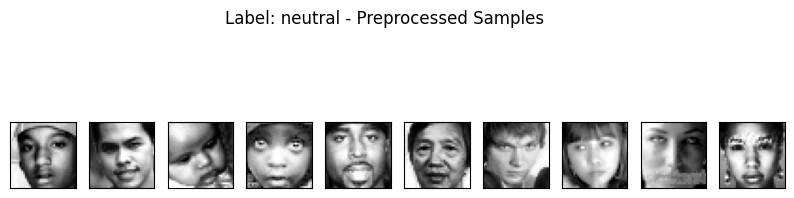

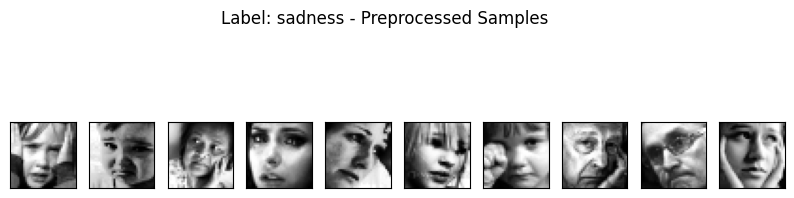

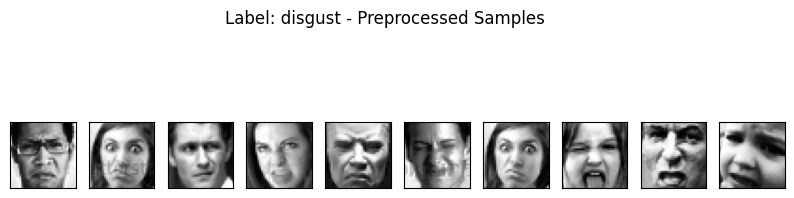

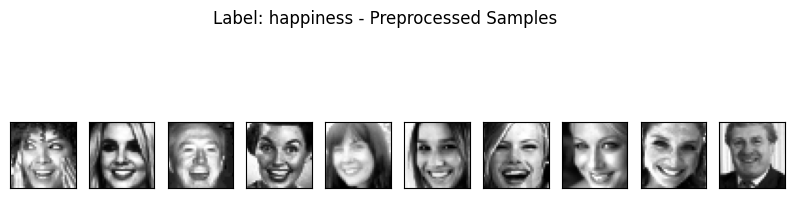

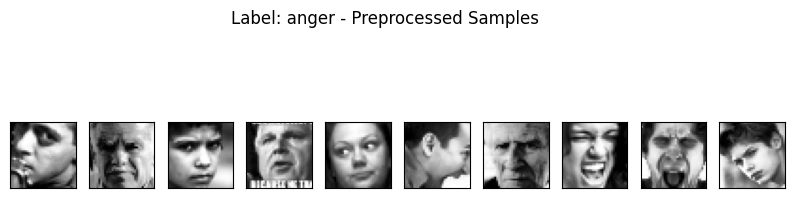

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img):
    # Ensure image is in the correct type for histogram equalization
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Histogram Equalization
    img_hist_eq = cv2.equalizeHist(img_uint8)
    
    return img_hist_eq

def plot_samples(X, y, labels_dict, n=10):
    for index, label in labels_dict.items():
        indices = np.where(y == index)[0]
        if len(indices) > n:
            indices = indices[:n]

        imgs = [preprocess_image(X[i]) for i in indices]
        j = 10  # Number of columns
        i = (n + j - 1) // j  # Number of rows calculated as ceiling of n/j

        plt.figure(figsize=(10, i*3))  # Increase the vertical size of the plot for more rows
        for idx, img in enumerate(imgs):
            plt.subplot(i, j, idx + 1)
            plt.imshow(img, cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f'Label: {label} - Preprocessed Samples')
        plt.show()

# Example usage
TRAIN_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train/'
TEST_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/'
IMG_SIZE = (35, 35)  # Correctly define IMG_SIZE as a tuple

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

# Print all labels
display_labels(train_labels)

# Display some sample images from the train set
plot_samples(X_train, y_train, train_labels, 10)


Labels in the dataset:
surprise
fear
neutral
sadness
disgust
happiness
anger


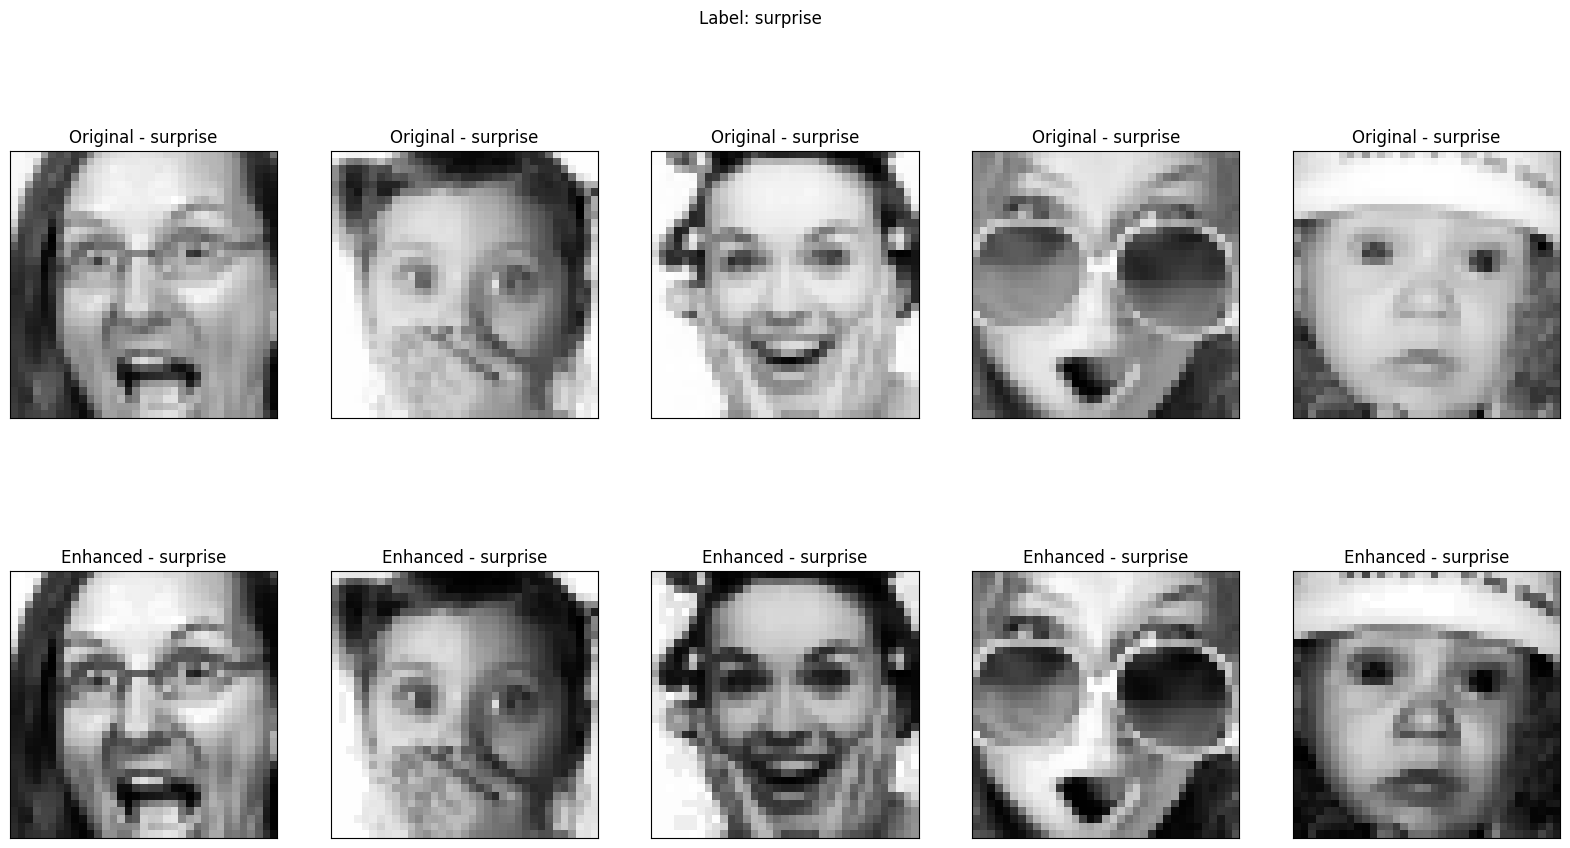

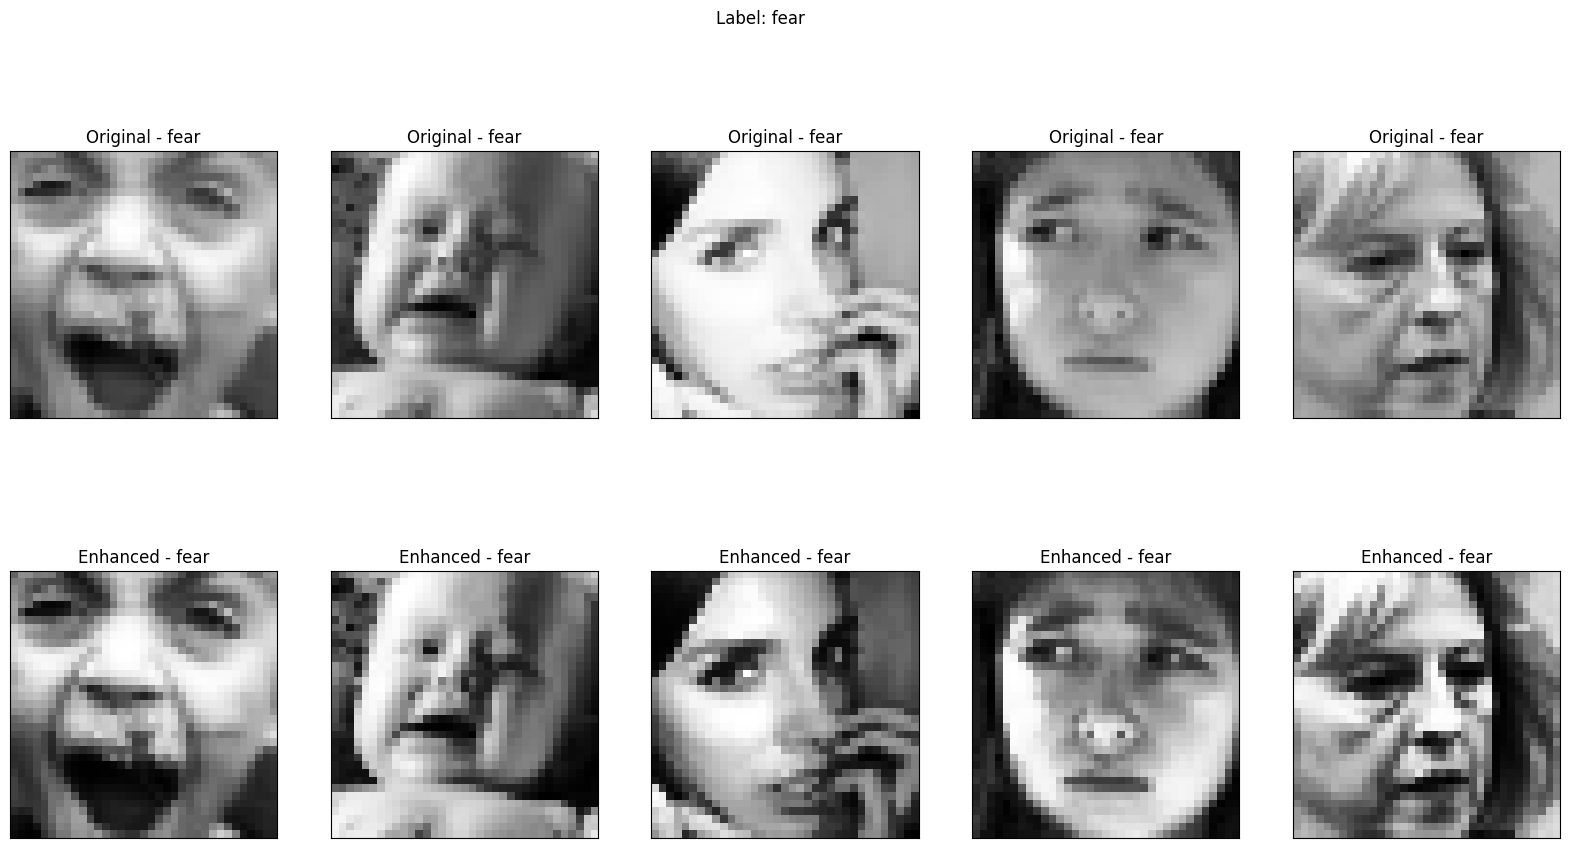

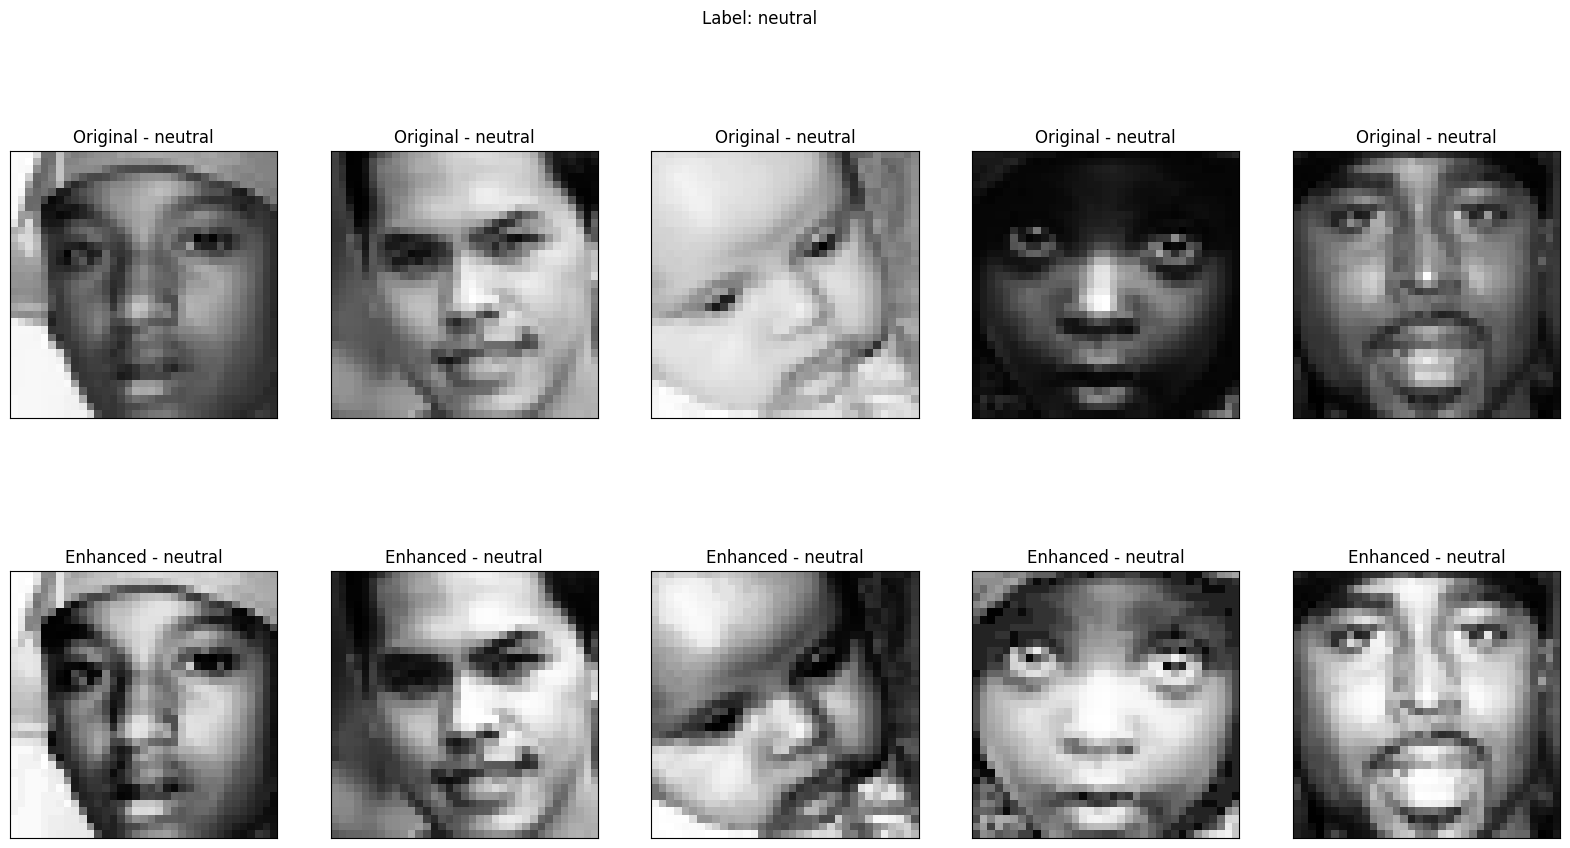

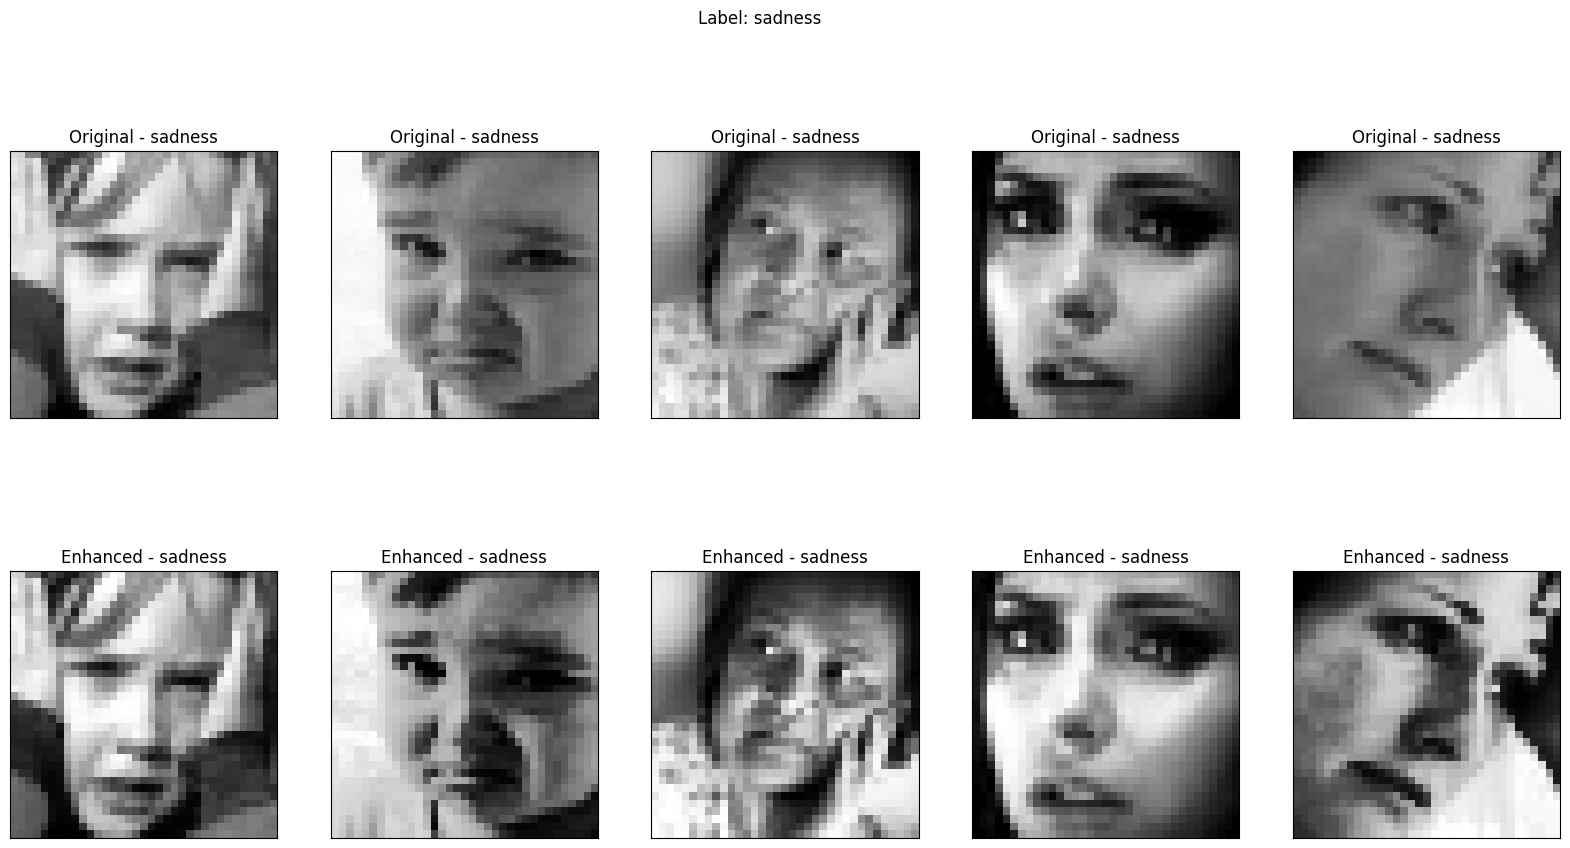

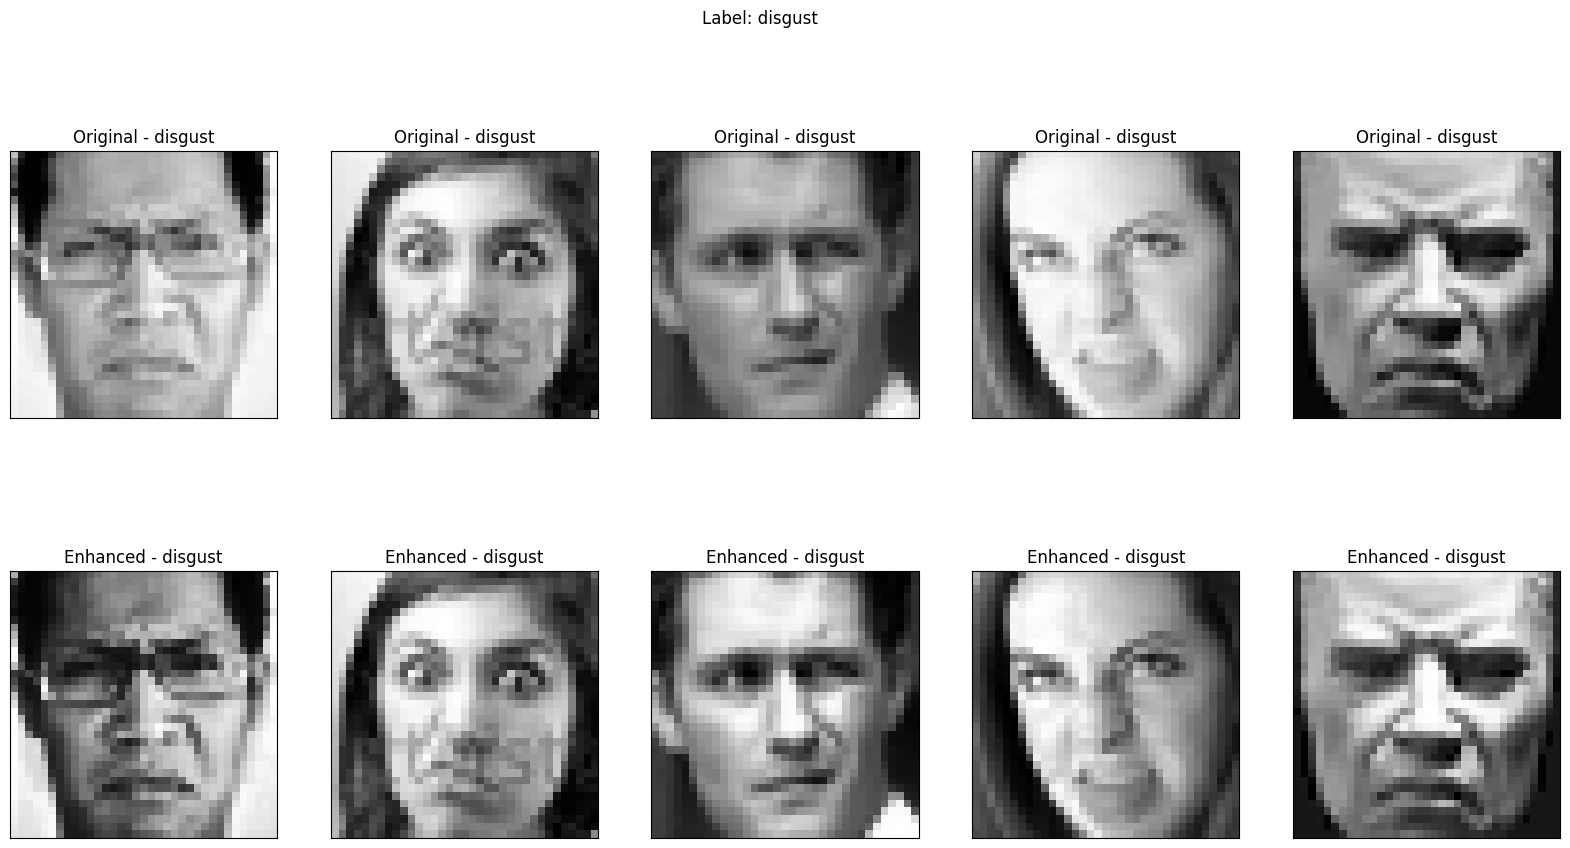

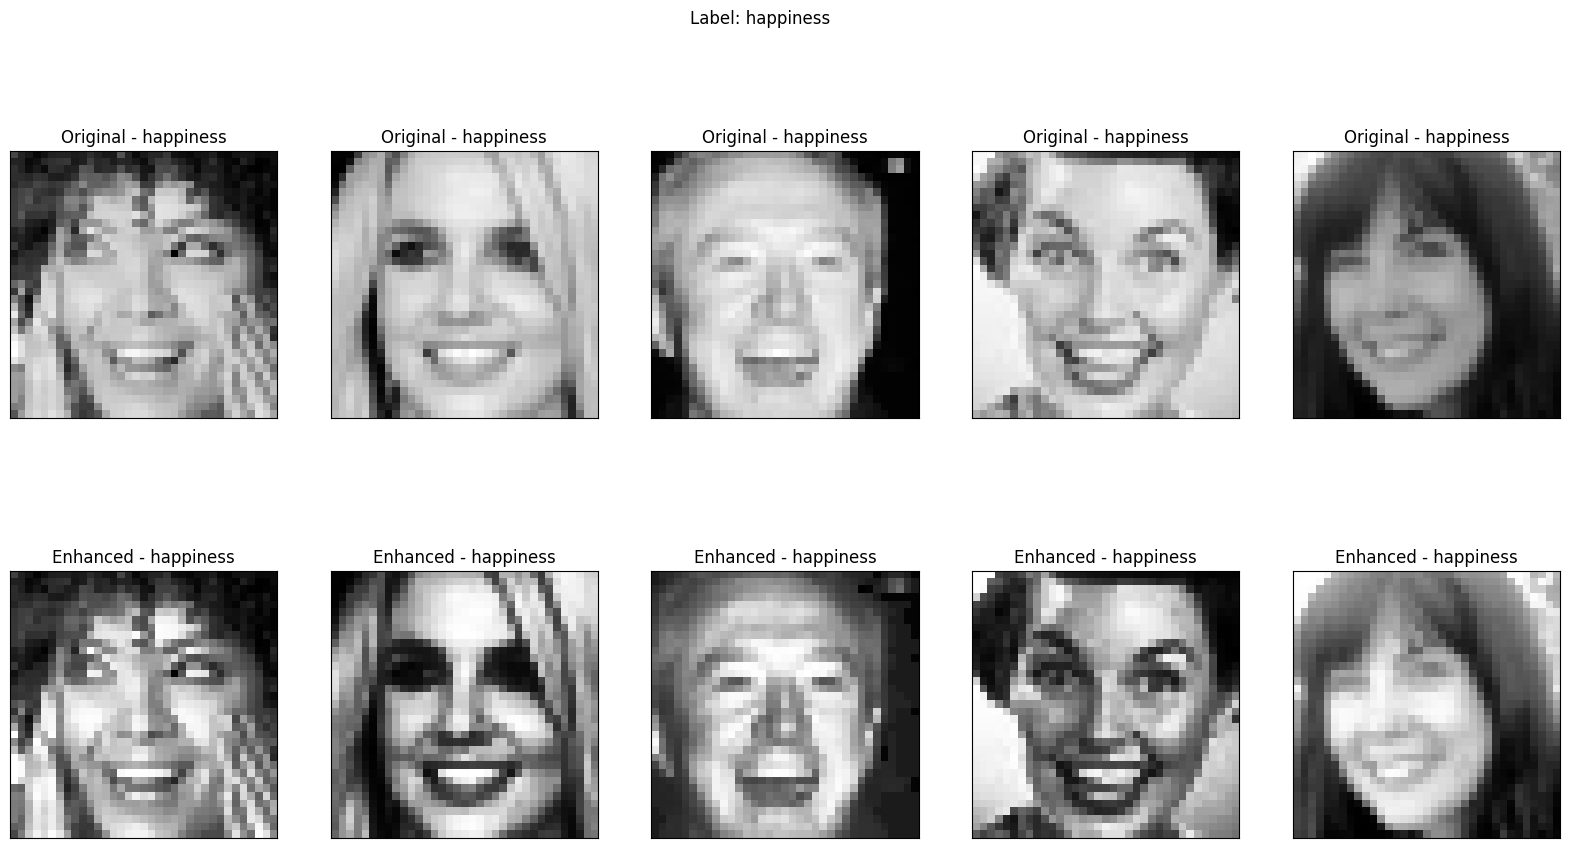

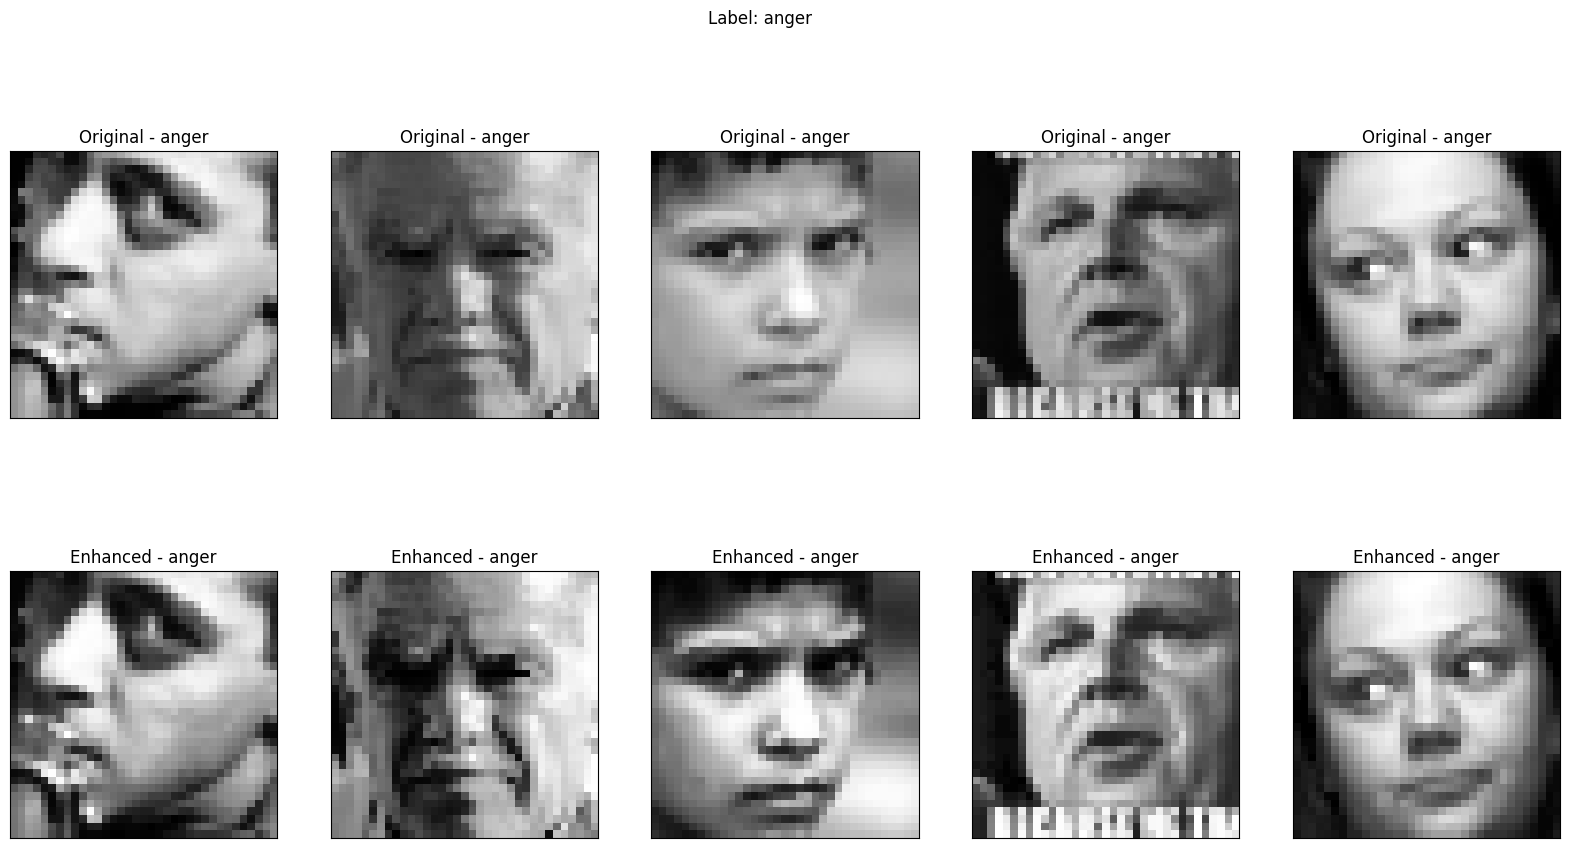

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img):
    # Ensure image is in the correct type for histogram equalization
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Histogram Equalization
    img_hist_eq = cv2.equalizeHist(img_uint8)
    
    return img_hist_eq

def plot_samples(X, y, labels_dict, n=5):
    for index, label in labels_dict.items():
        indices = np.where(y == index)[0]
        if len(indices) > n:
            indices = indices[:n]

        imgs = [X[i] for i in indices]
        processed_imgs = [preprocess_image(X[i]) for i in indices]
        num_imgs = len(imgs)

        plt.figure(figsize=(20, num_imgs*2))  # Adjusted size for better visibility
        for idx in range(num_imgs):
            # Plot original image
            plt.subplot(2, num_imgs, idx + 1)
            plt.imshow(imgs[idx], cmap='gray')
            plt.title(f'Original - {label}')
            plt.xticks([])
            plt.yticks([])

            # Plot processed image
            plt.subplot(2, num_imgs, idx + 1 + num_imgs)
            plt.imshow(processed_imgs[idx], cmap='gray')
            plt.title(f'Enhanced - {label}')
            plt.xticks([])
            plt.yticks([])

        plt.suptitle(f'Label: {label}')
        plt.show()

# Assume the following functions are defined elsewhere in your script:
# load_data, display_labels

# Example usage
TRAIN_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train/'
TEST_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/'
IMG_SIZE = (35, 35)  # Correctly define IMG_SIZE as a tuple

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

# Print all labels
display_labels(train_labels)

# Display some sample images from the train set
plot_samples(X_train, y_train, train_labels, 5)


Labels in the dataset:
surprise
fear
neutral
sadness
disgust
happiness
anger
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


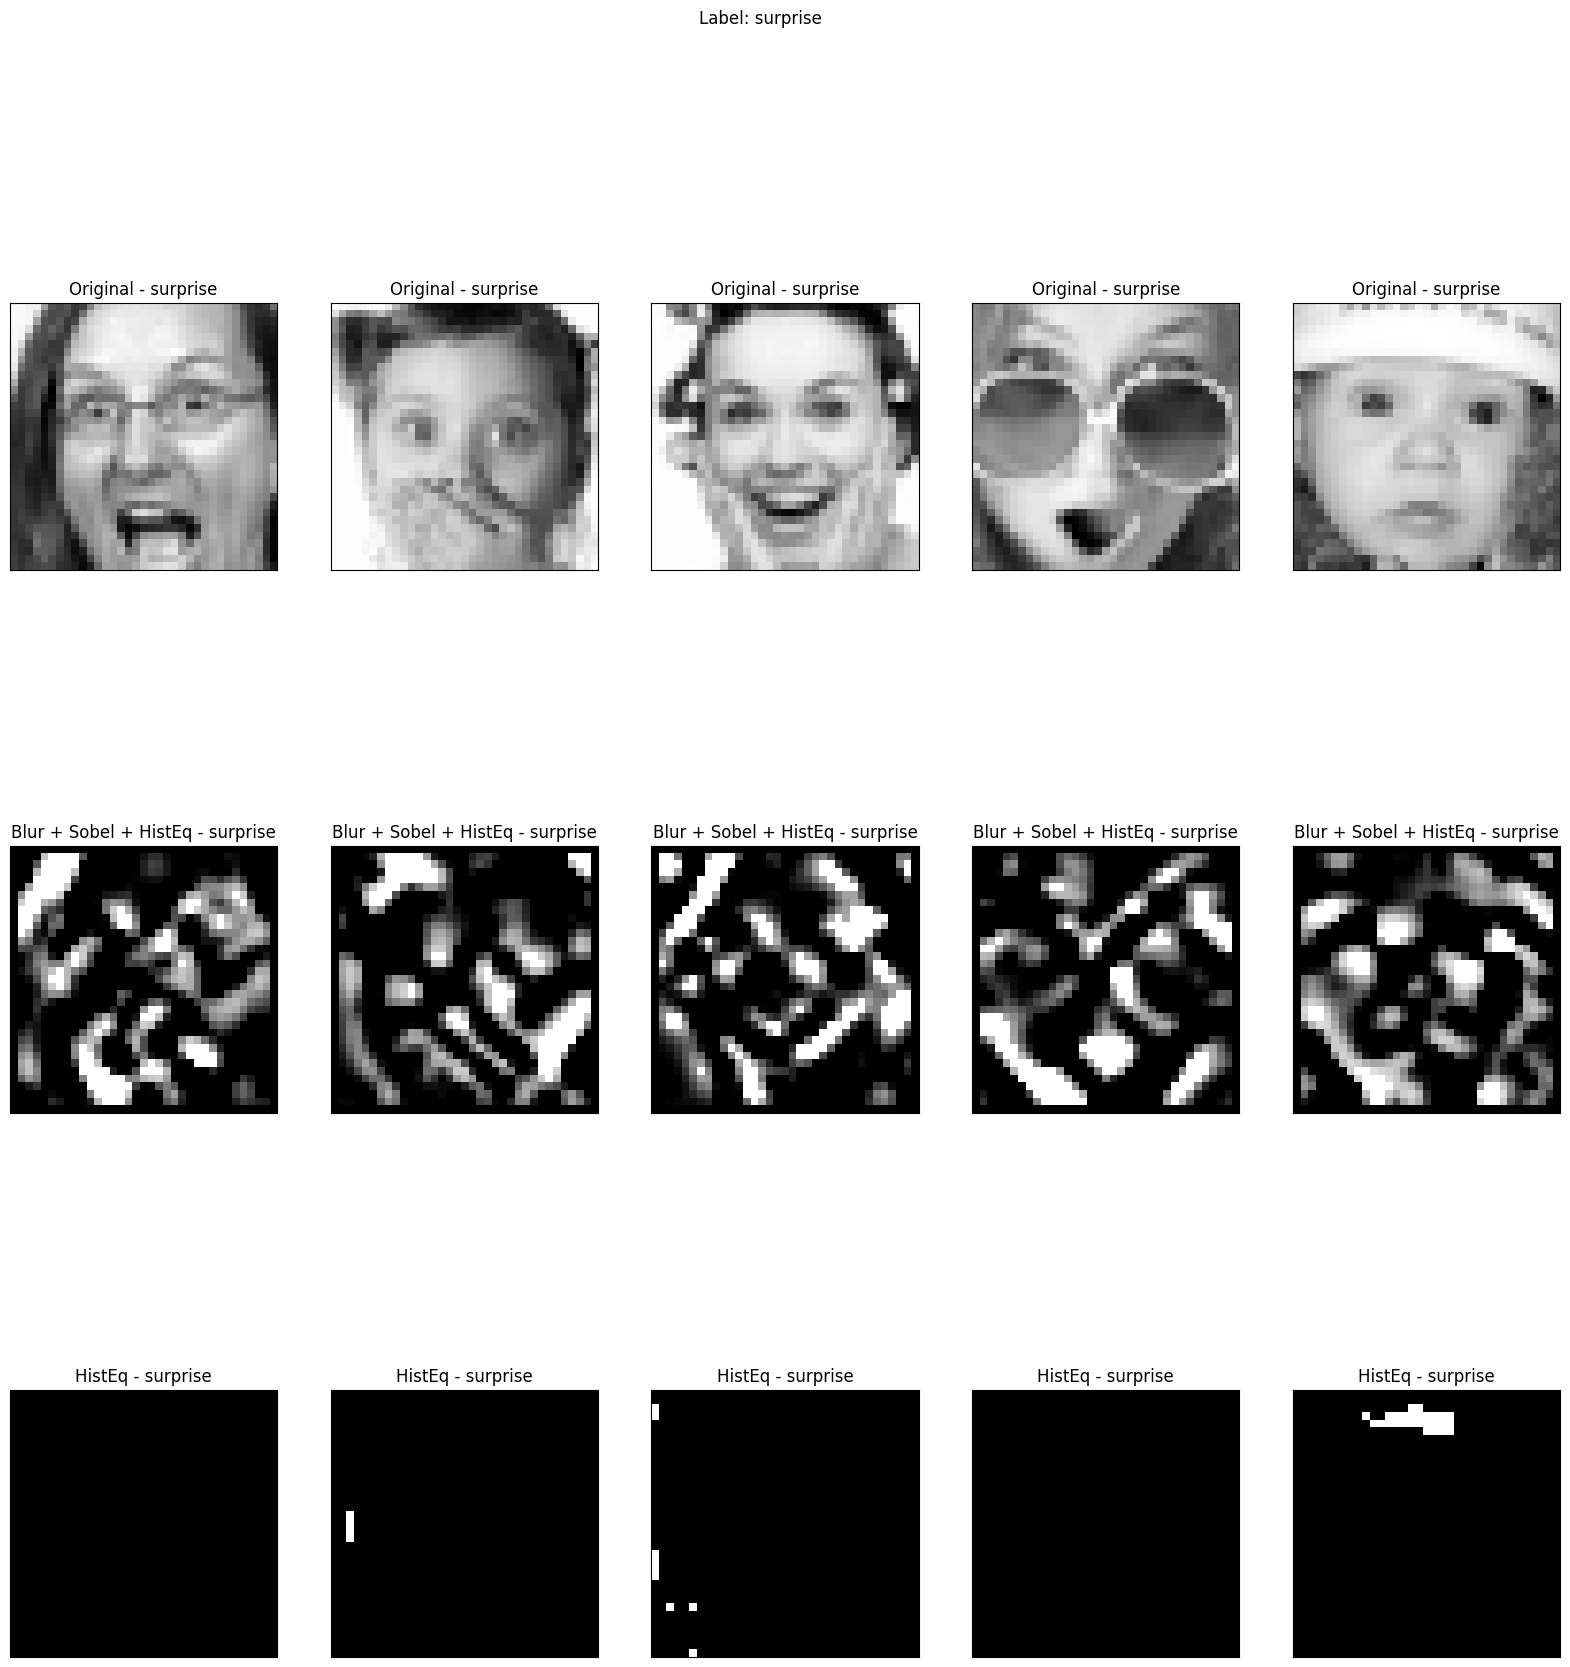

Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


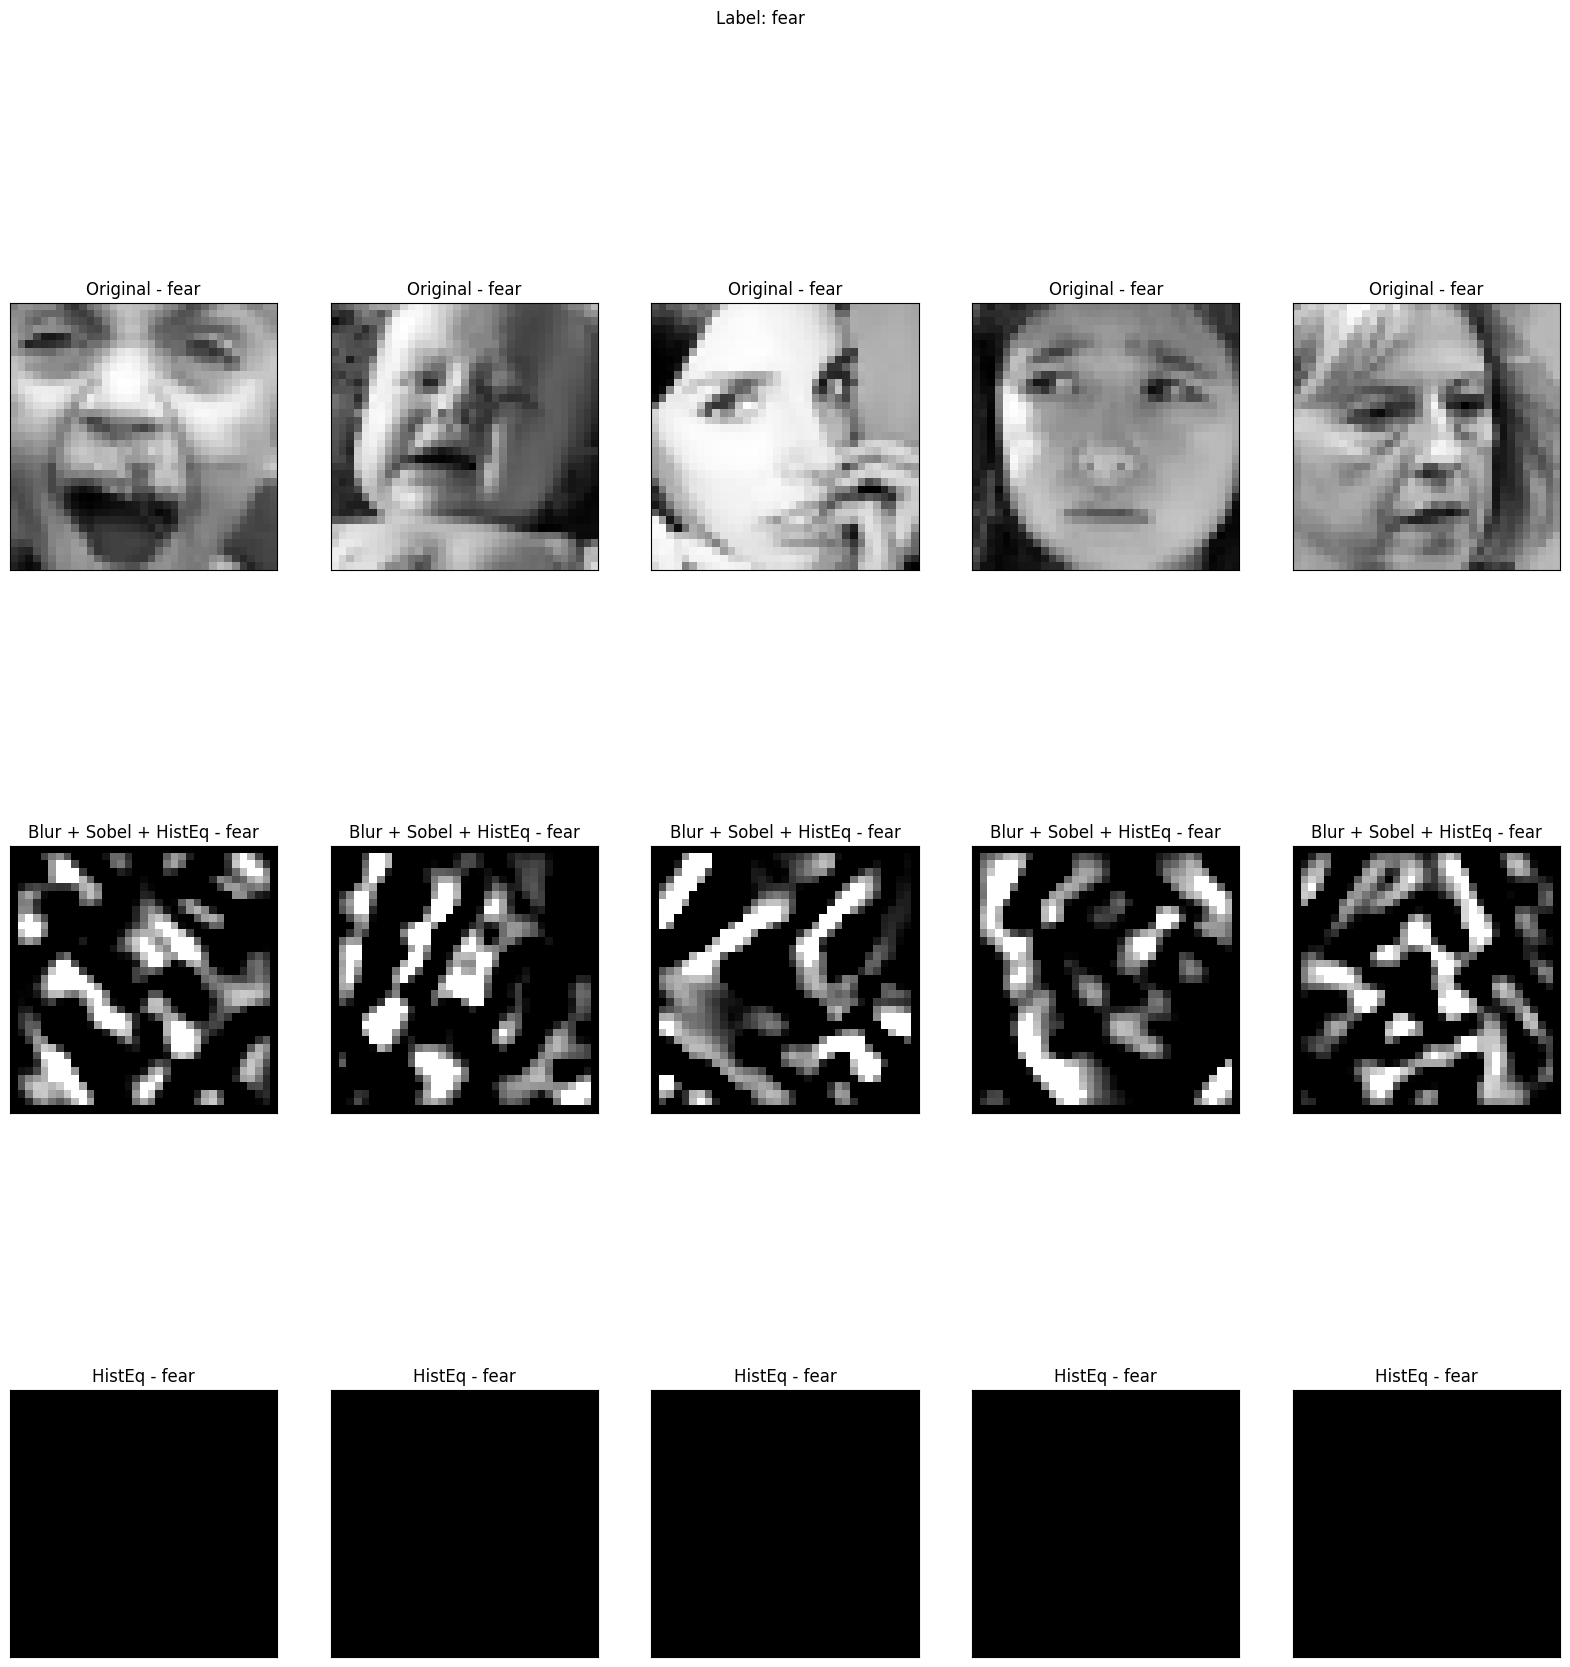

Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


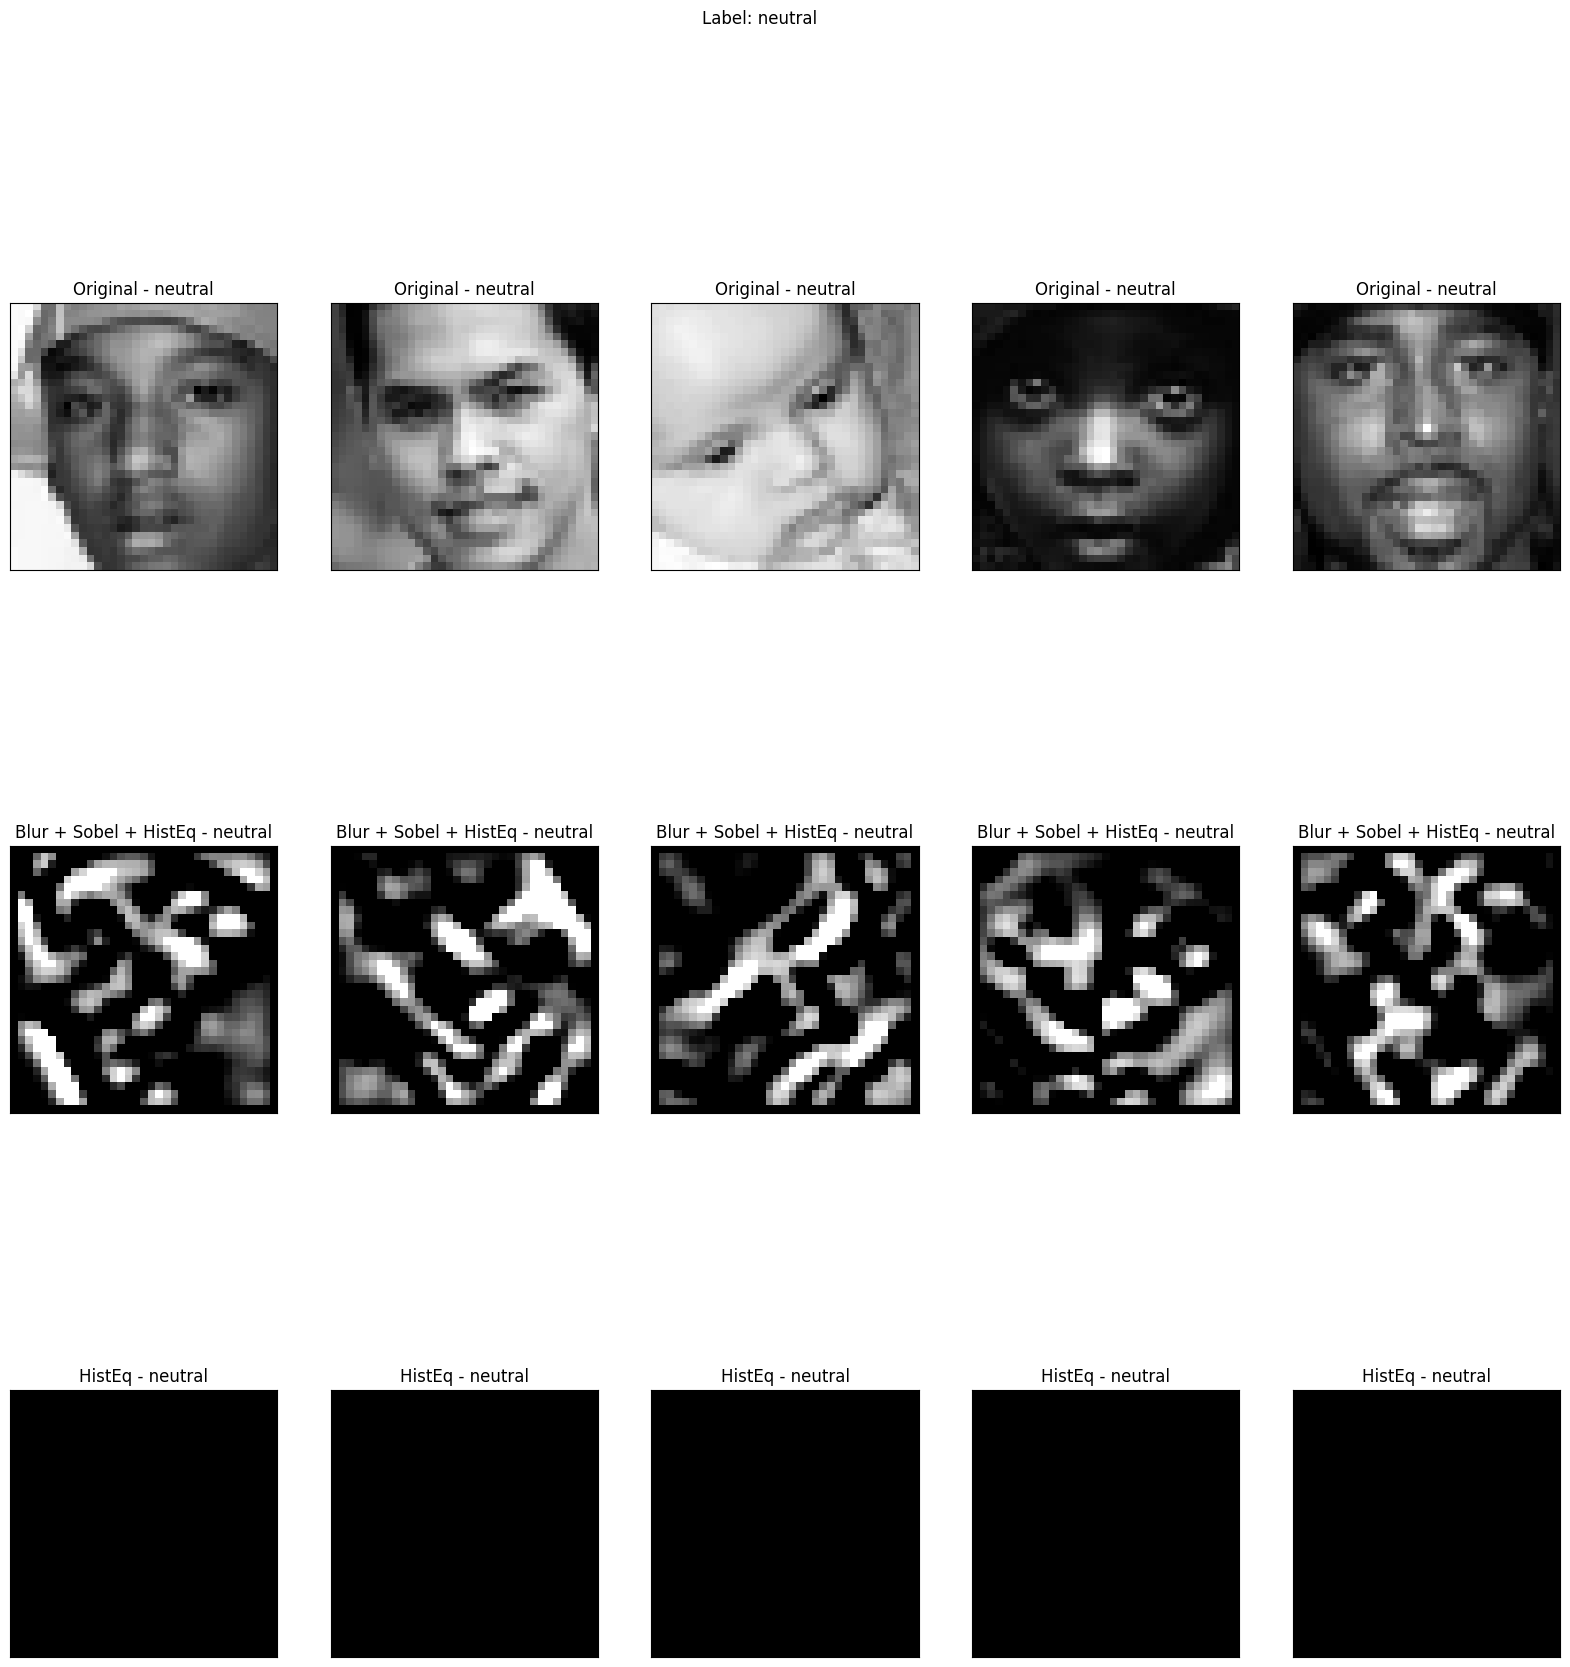

Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


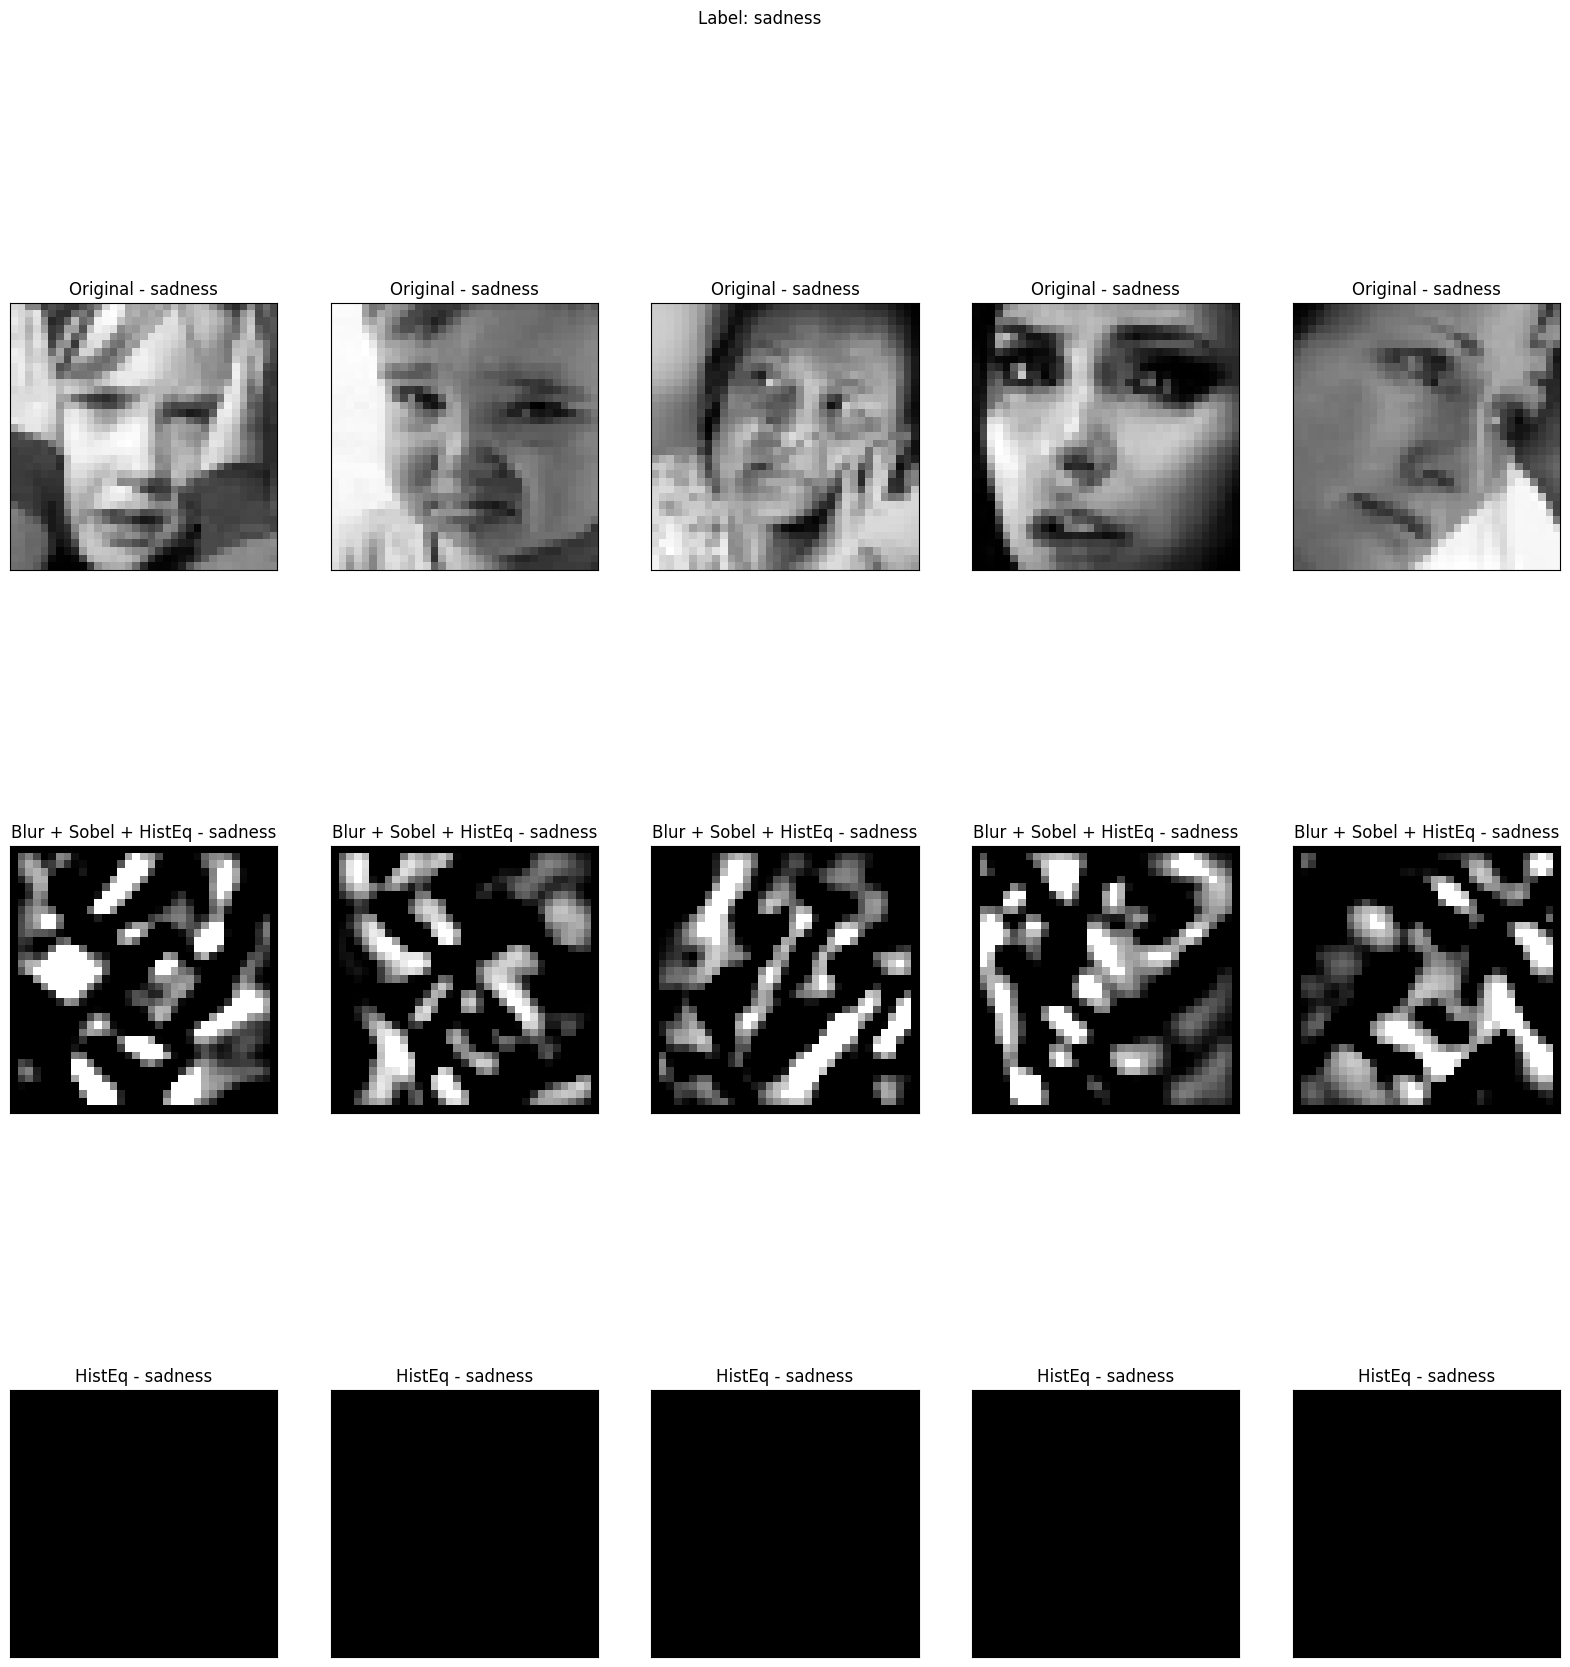

Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


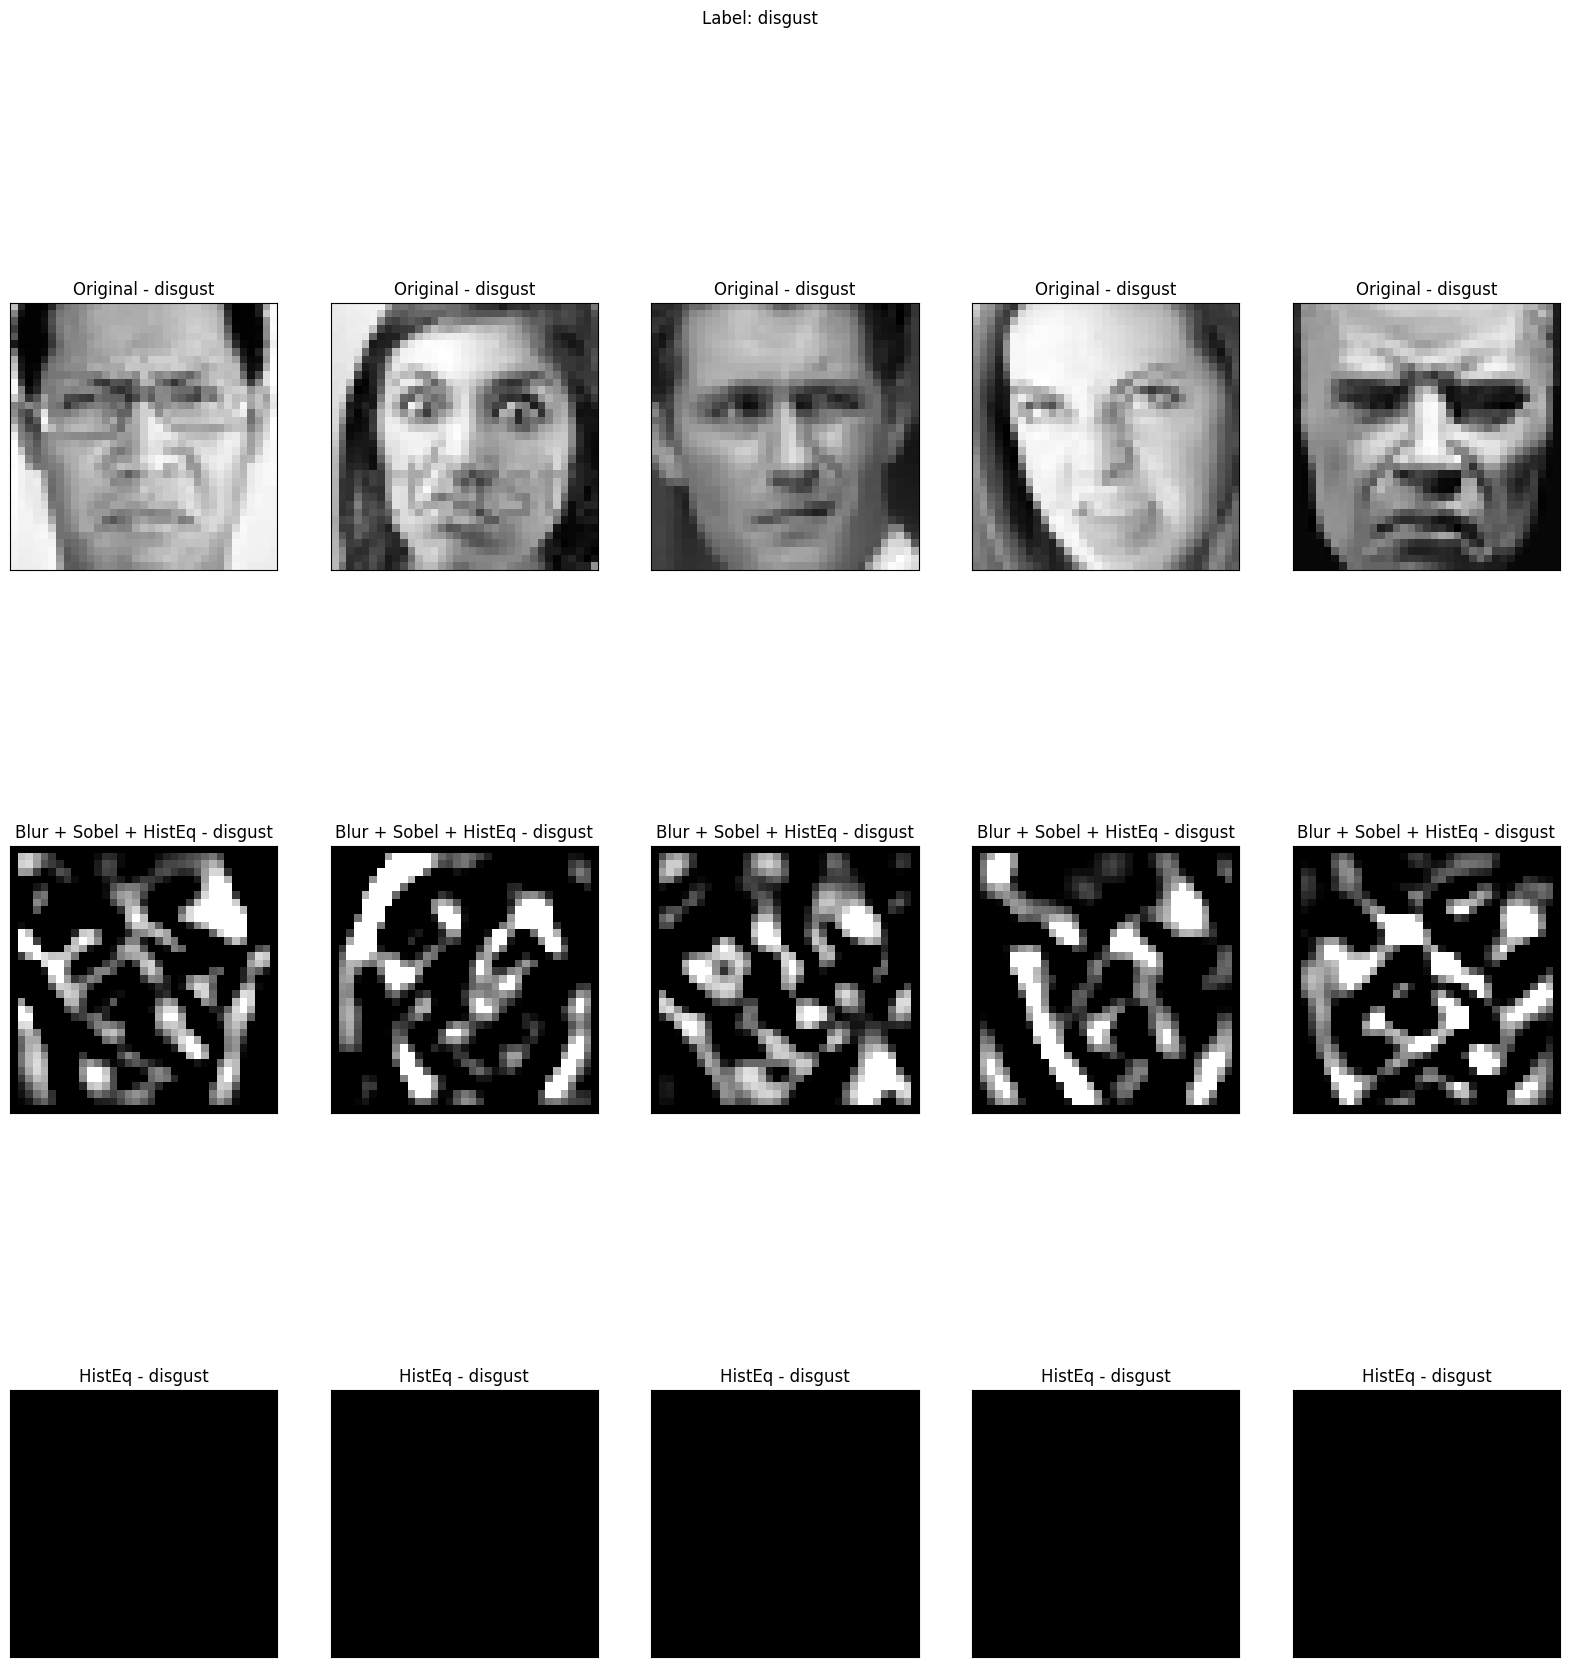

Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


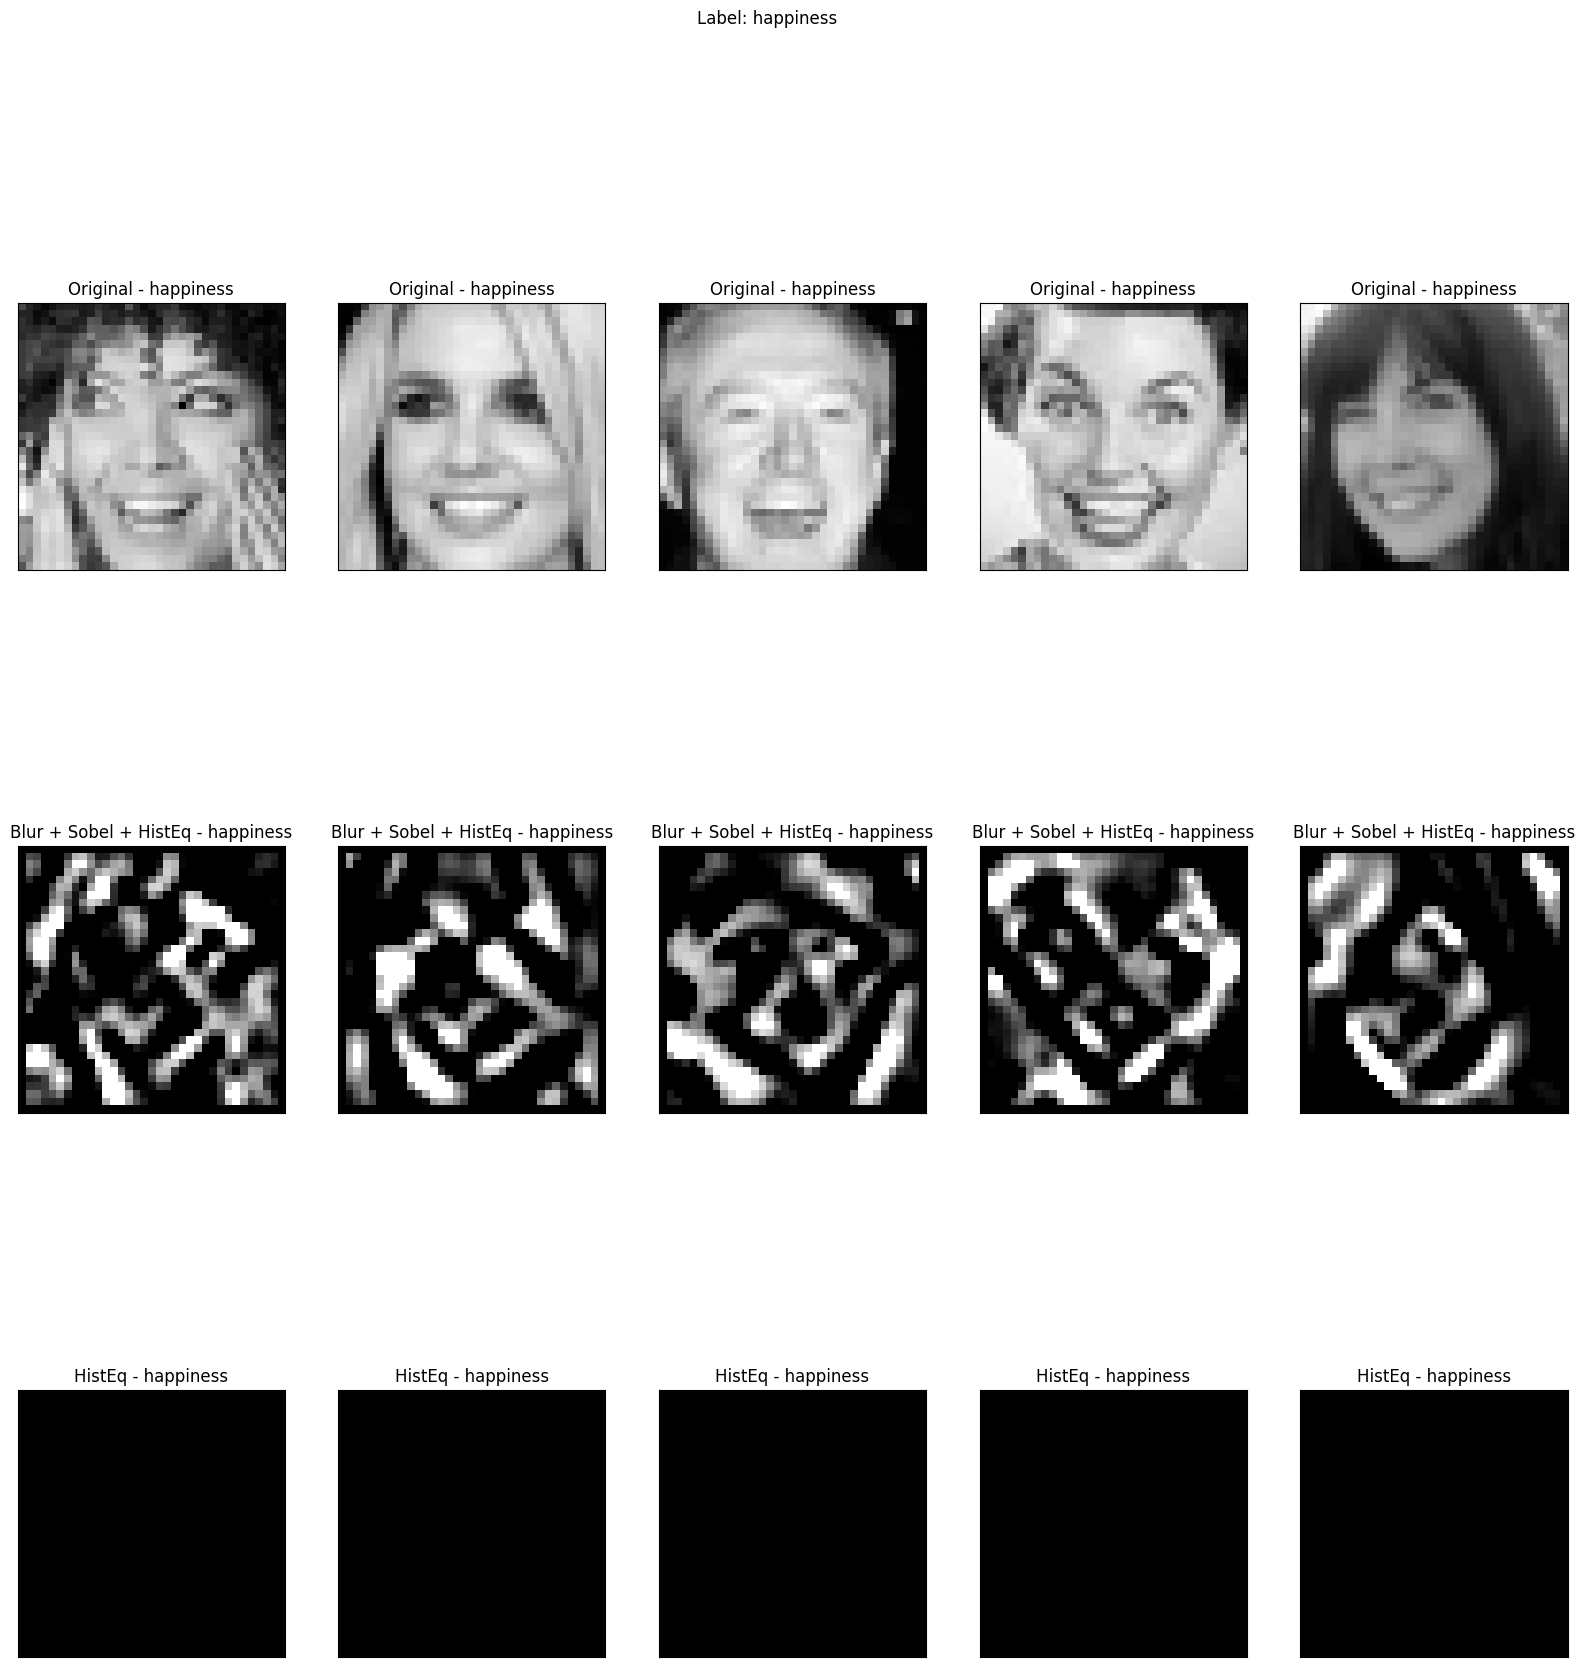

Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32
Image shape: (35, 35), Image dtype: float32


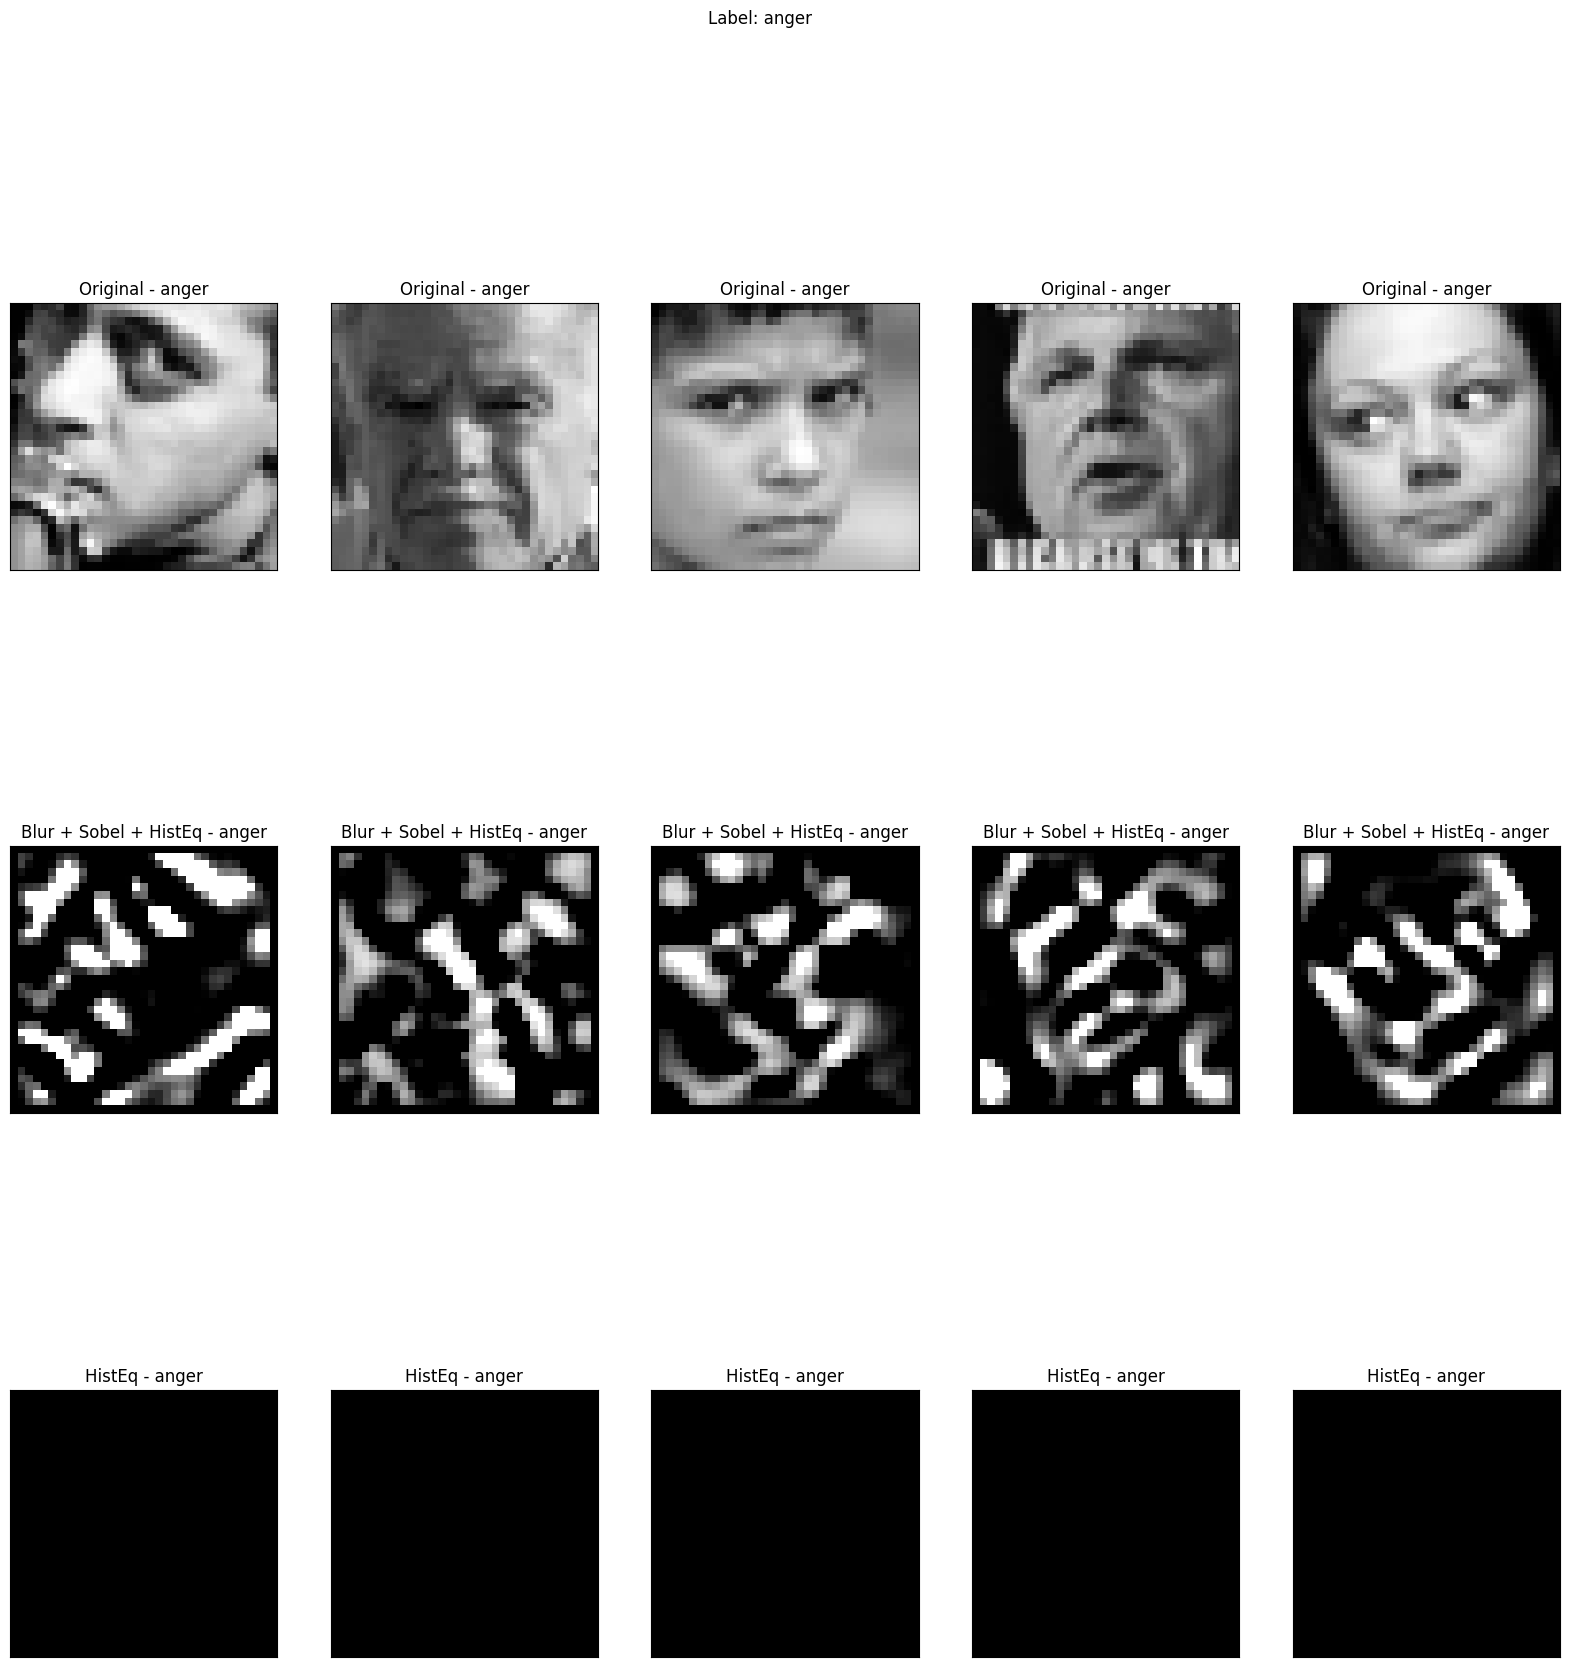

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_data(dir_path, img_size):
    labels = {}
    data = []
    labels_list = []
    class_count = 0

    # Iterate over directory
    for i, path in enumerate(os.listdir(dir_path)):
        if not path.startswith('.'):  # Ignore hidden files/folders
            class_path = os.path.join(dir_path, path)  # Use os.path.join for correct path
            labels[i] = path
            for file in os.listdir(class_path):
                if not file.startswith('.'):
                    img_path = os.path.join(class_path, file)  # Use os.path.join for correct path
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                    if img is None:
                        print(f"Warning: Could not load image at {img_path}. It may be corrupt or the path may be incorrect.")
                        continue
                    img = cv2.resize(img, img_size)  # Resize the image to the specified IMG_SIZE
                    data.append(img)
                    labels_list.append(class_count)
            class_count += 1

    data = np.array(data, dtype='float32') / 255.0  # Normalize the data
    labels_list = np.array(labels_list)
    return data, labels_list, labels

def display_labels(labels):
    print("Labels in the dataset:")
    for label in labels.values():
        print(label)

def preprocess_image(img, apply_gaussian_blur=True, apply_sobel_filter=True):
    # Ensure image is in the correct type for histogram equalization
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Optionally apply Gaussian Blur
    if apply_gaussian_blur:
        img_uint8 = cv2.GaussianBlur(img_uint8, (5, 5), 0)
    
    # Optionally apply Sobel filter
    if apply_sobel_filter:
        img_uint8 = cv2.Sobel(img_uint8, cv2.CV_8U, 1, 1, ksize=5)
    
    # Convert image to single-channel (grayscale) if it's not already
    if len(img_uint8.shape) > 2:
        img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    
    # Histogram Equalization
    img_hist_eq = cv2.equalizeHist(img_uint8)
    
    return img_hist_eq

def plot_samples(X, y, labels_dict, n=5):
    for index, label in labels_dict.items():
        indices = np.where(y == index)[0]
        if len(indices) > n:
            indices = indices[:n]

        imgs = [X[i] for i in indices]
        processed_imgs = [preprocess_image(X[i]) for i in indices]
        num_imgs = len(imgs)

        plt.figure(figsize=(20, num_imgs * 4))  # Adjusted size for better visibility
        for idx in range(num_imgs):
            # Plot original image
            plt.subplot(3, num_imgs, idx + 1)
            plt.imshow(imgs[idx], cmap='gray')
            plt.title(f'Original - {label}')
            plt.xticks([])
            plt.yticks([])

            # Plot processed image with Gaussian Blur and Sobel filter
            plt.subplot(3, num_imgs, idx + 1 + num_imgs)
            plt.imshow(processed_imgs[idx], cmap='gray')
            plt.title(f'Blur + Sobel + HistEq - {label}')
            plt.xticks([])
            plt.yticks([])

            # Plot histogram equalized image
            plt.subplot(3, num_imgs, idx + 1 + 2 * num_imgs)
            print(f"Image shape: {imgs[idx].shape}, Image dtype: {imgs[idx].dtype}")
            plt.imshow(cv2.equalizeHist(imgs[idx].astype(np.uint8)), cmap='gray')
            plt.title(f'HistEq - {label}')
            plt.xticks([])
            plt.yticks([])

        plt.suptitle(f'Label: {label}')
        plt.show()

# Example usage
TRAIN_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train/'
TEST_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/'
IMG_SIZE = (35, 35)  # Correctly define IMG_SIZE as a tuple

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

# Print all labels
display_labels(train_labels)

# Display some sample images from the train set
plot_samples(X_train, y_train, train_labels, 5)


Labels in the dataset:
surprise
fear
neutral
sadness
disgust
happiness
anger


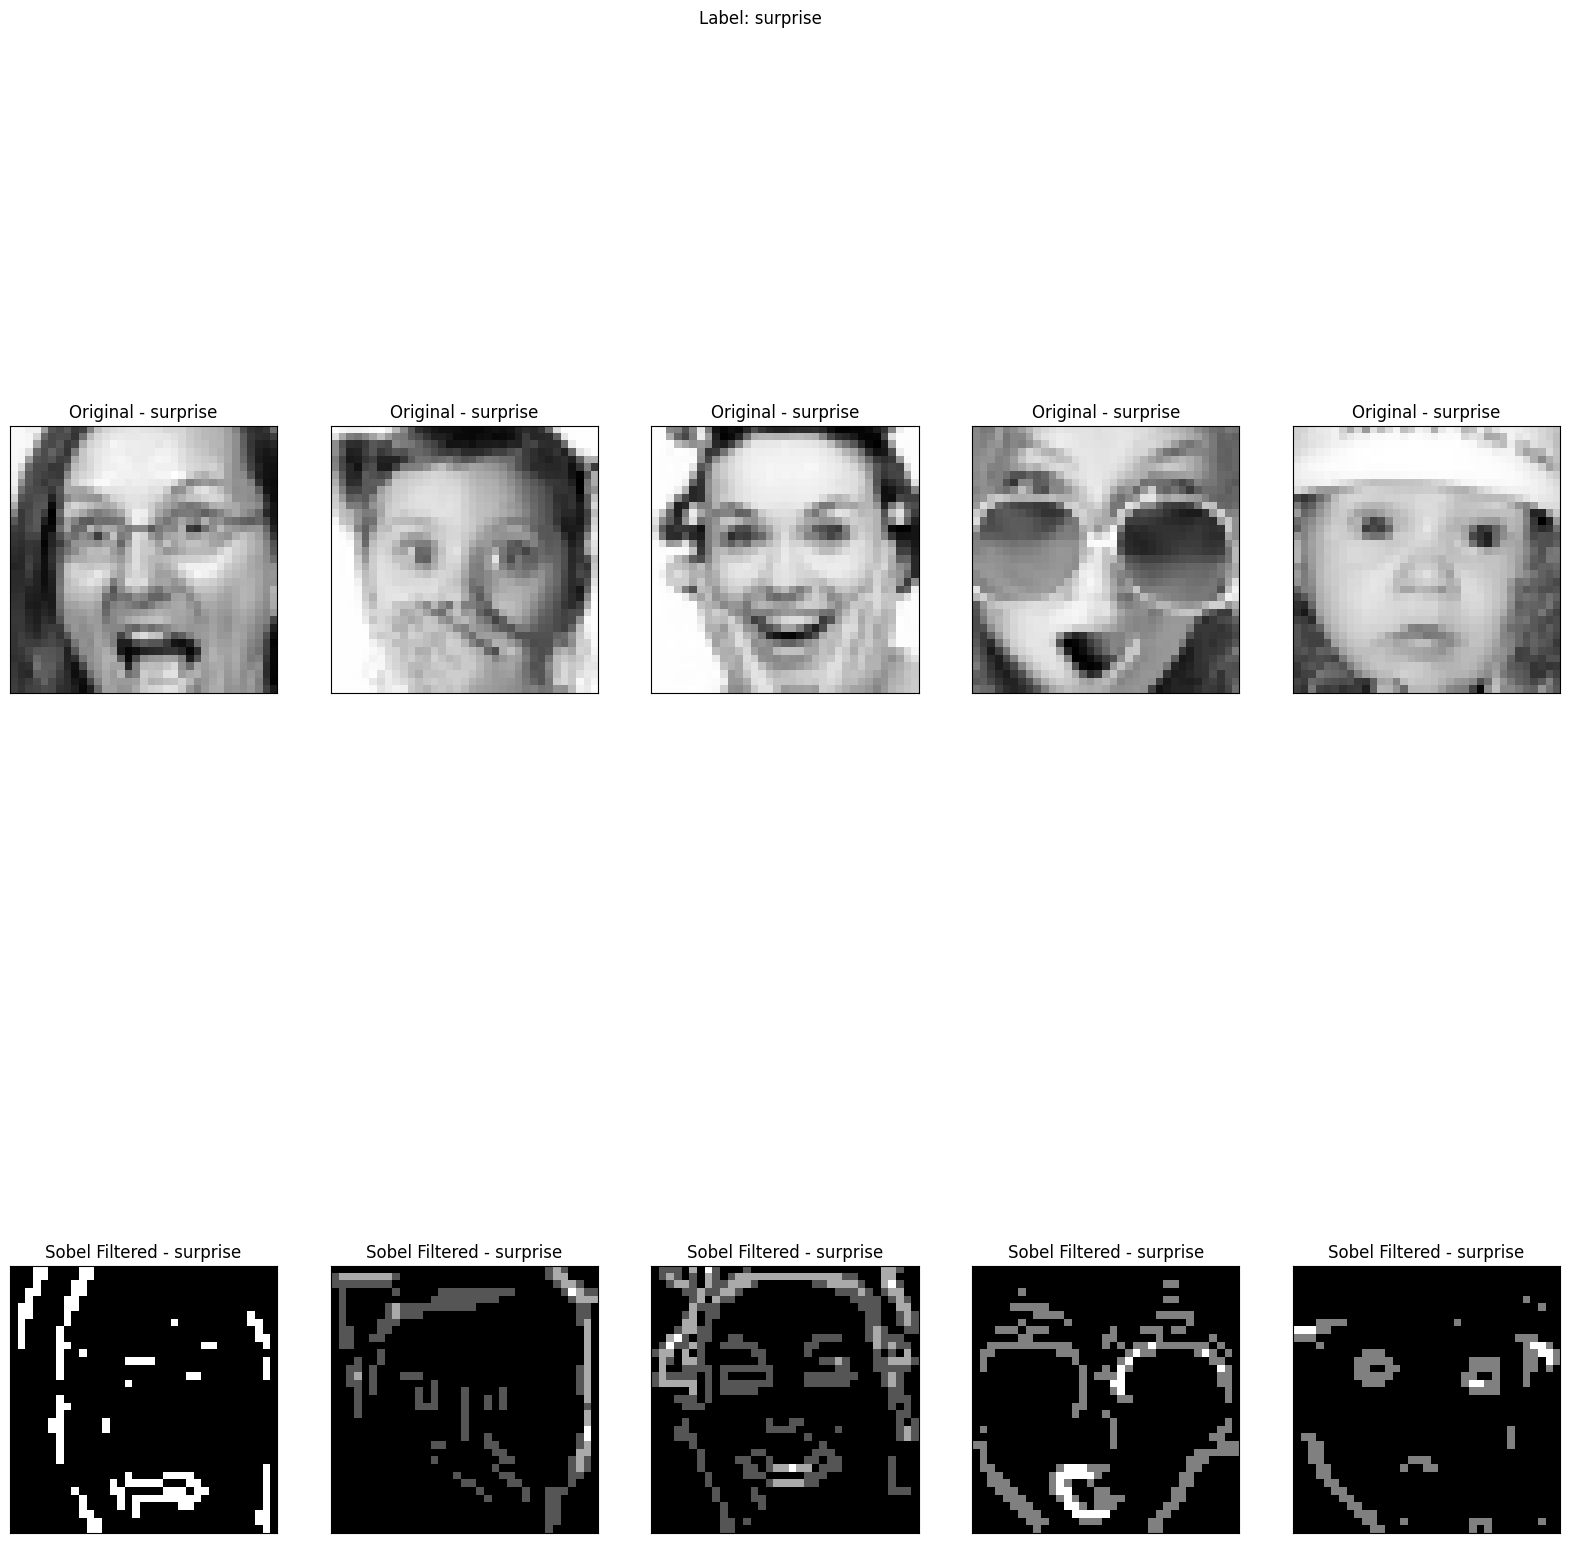

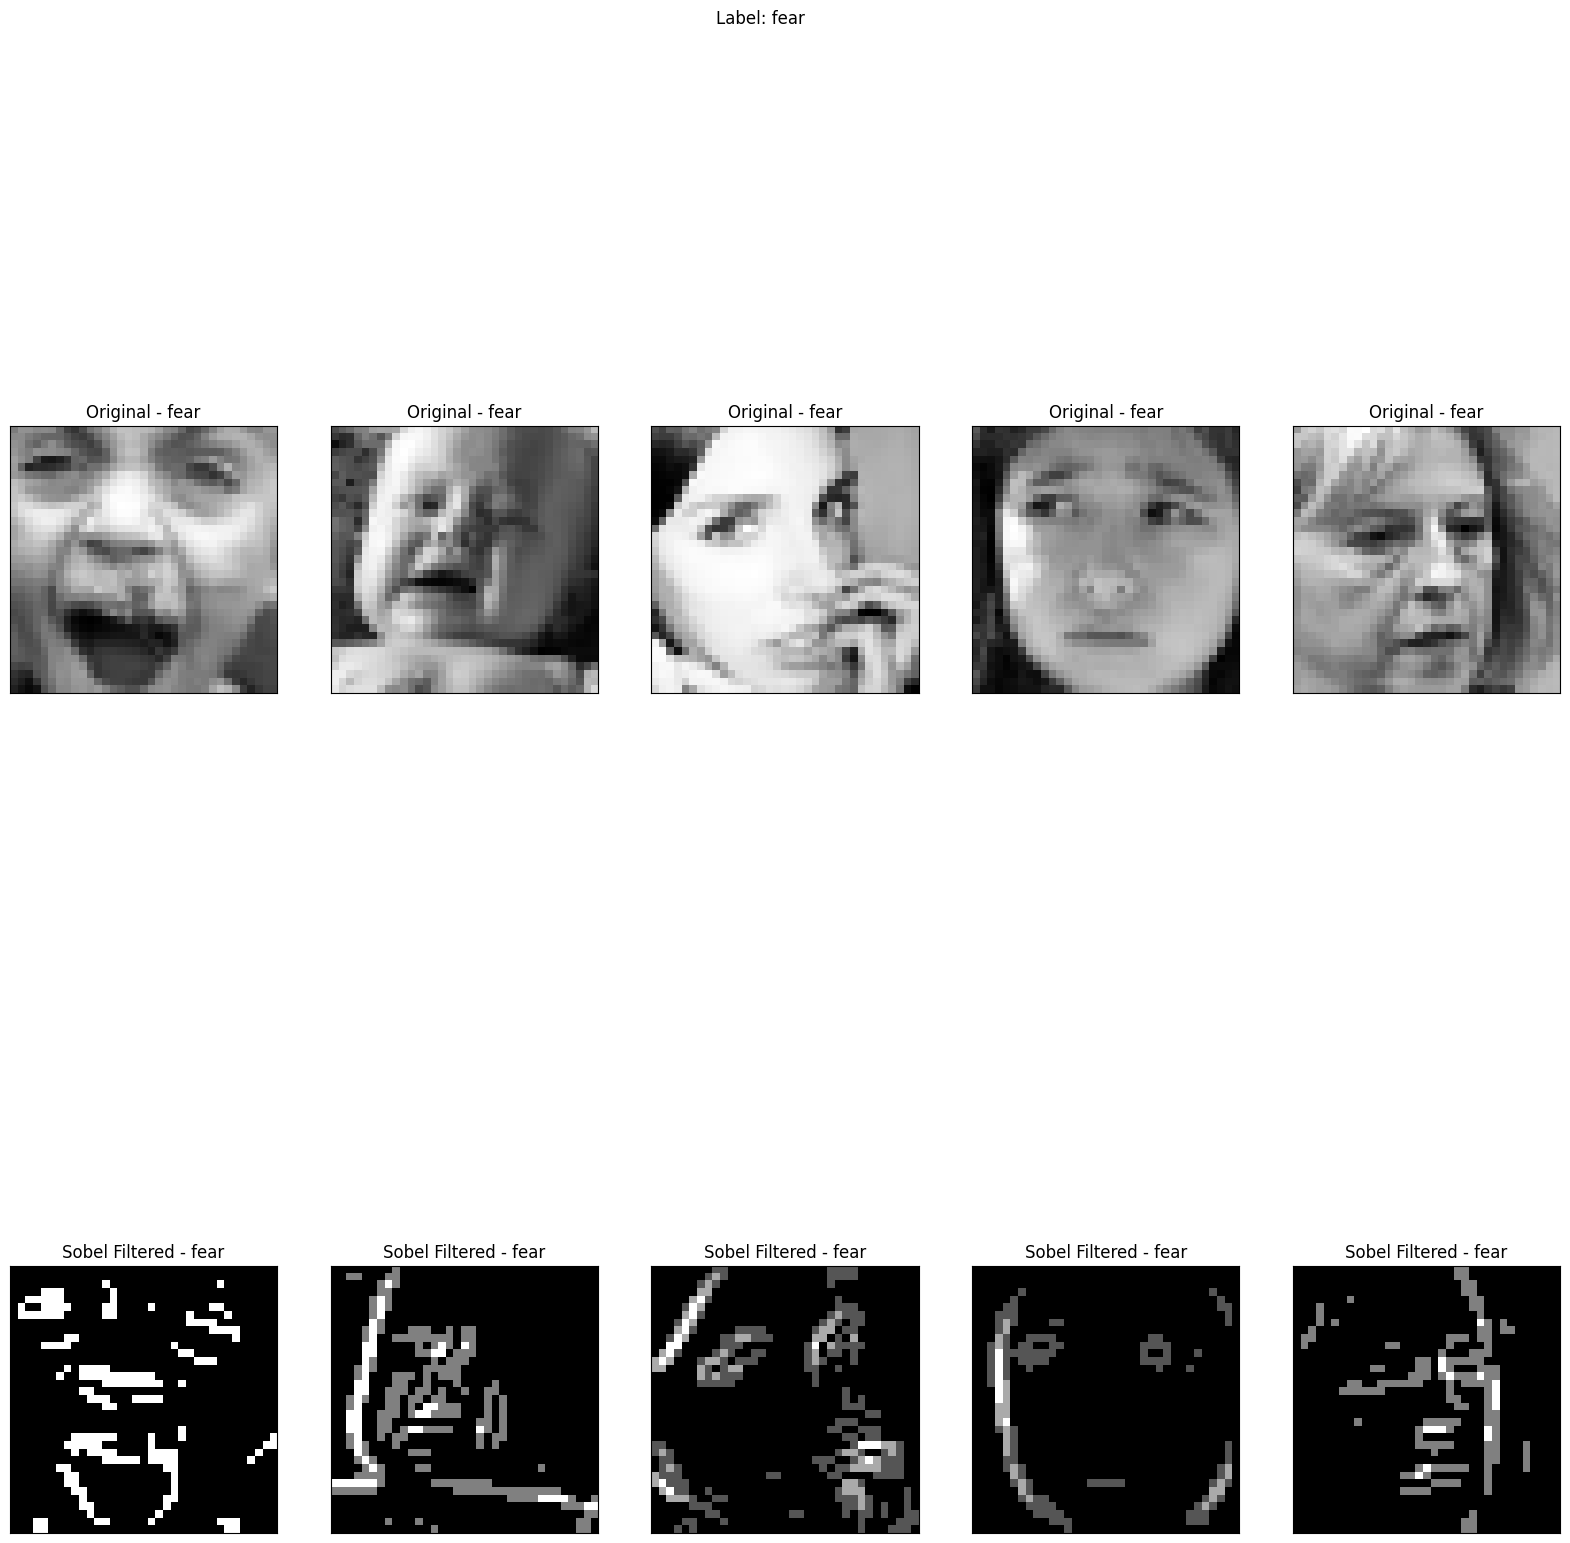

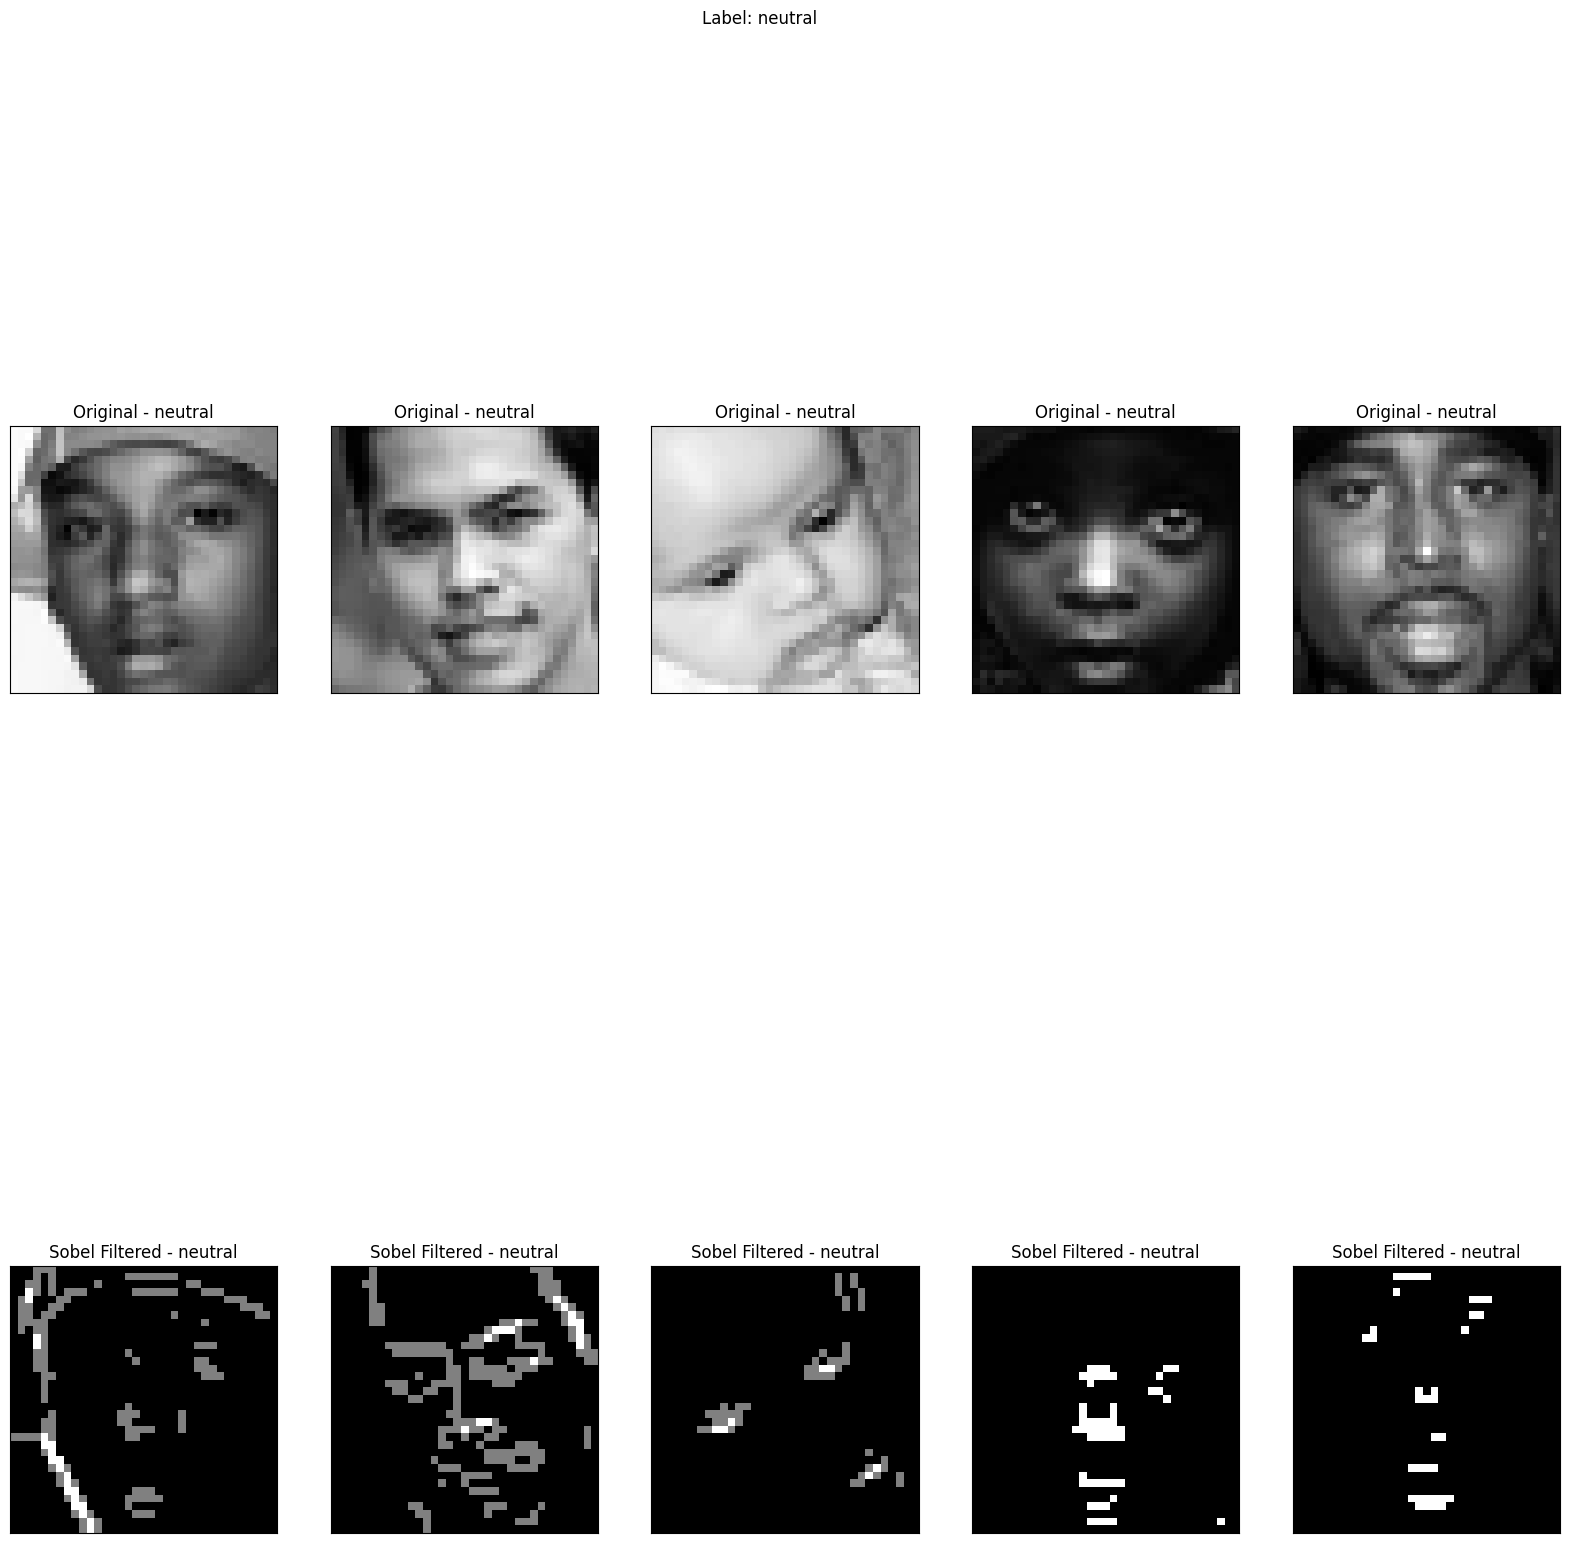

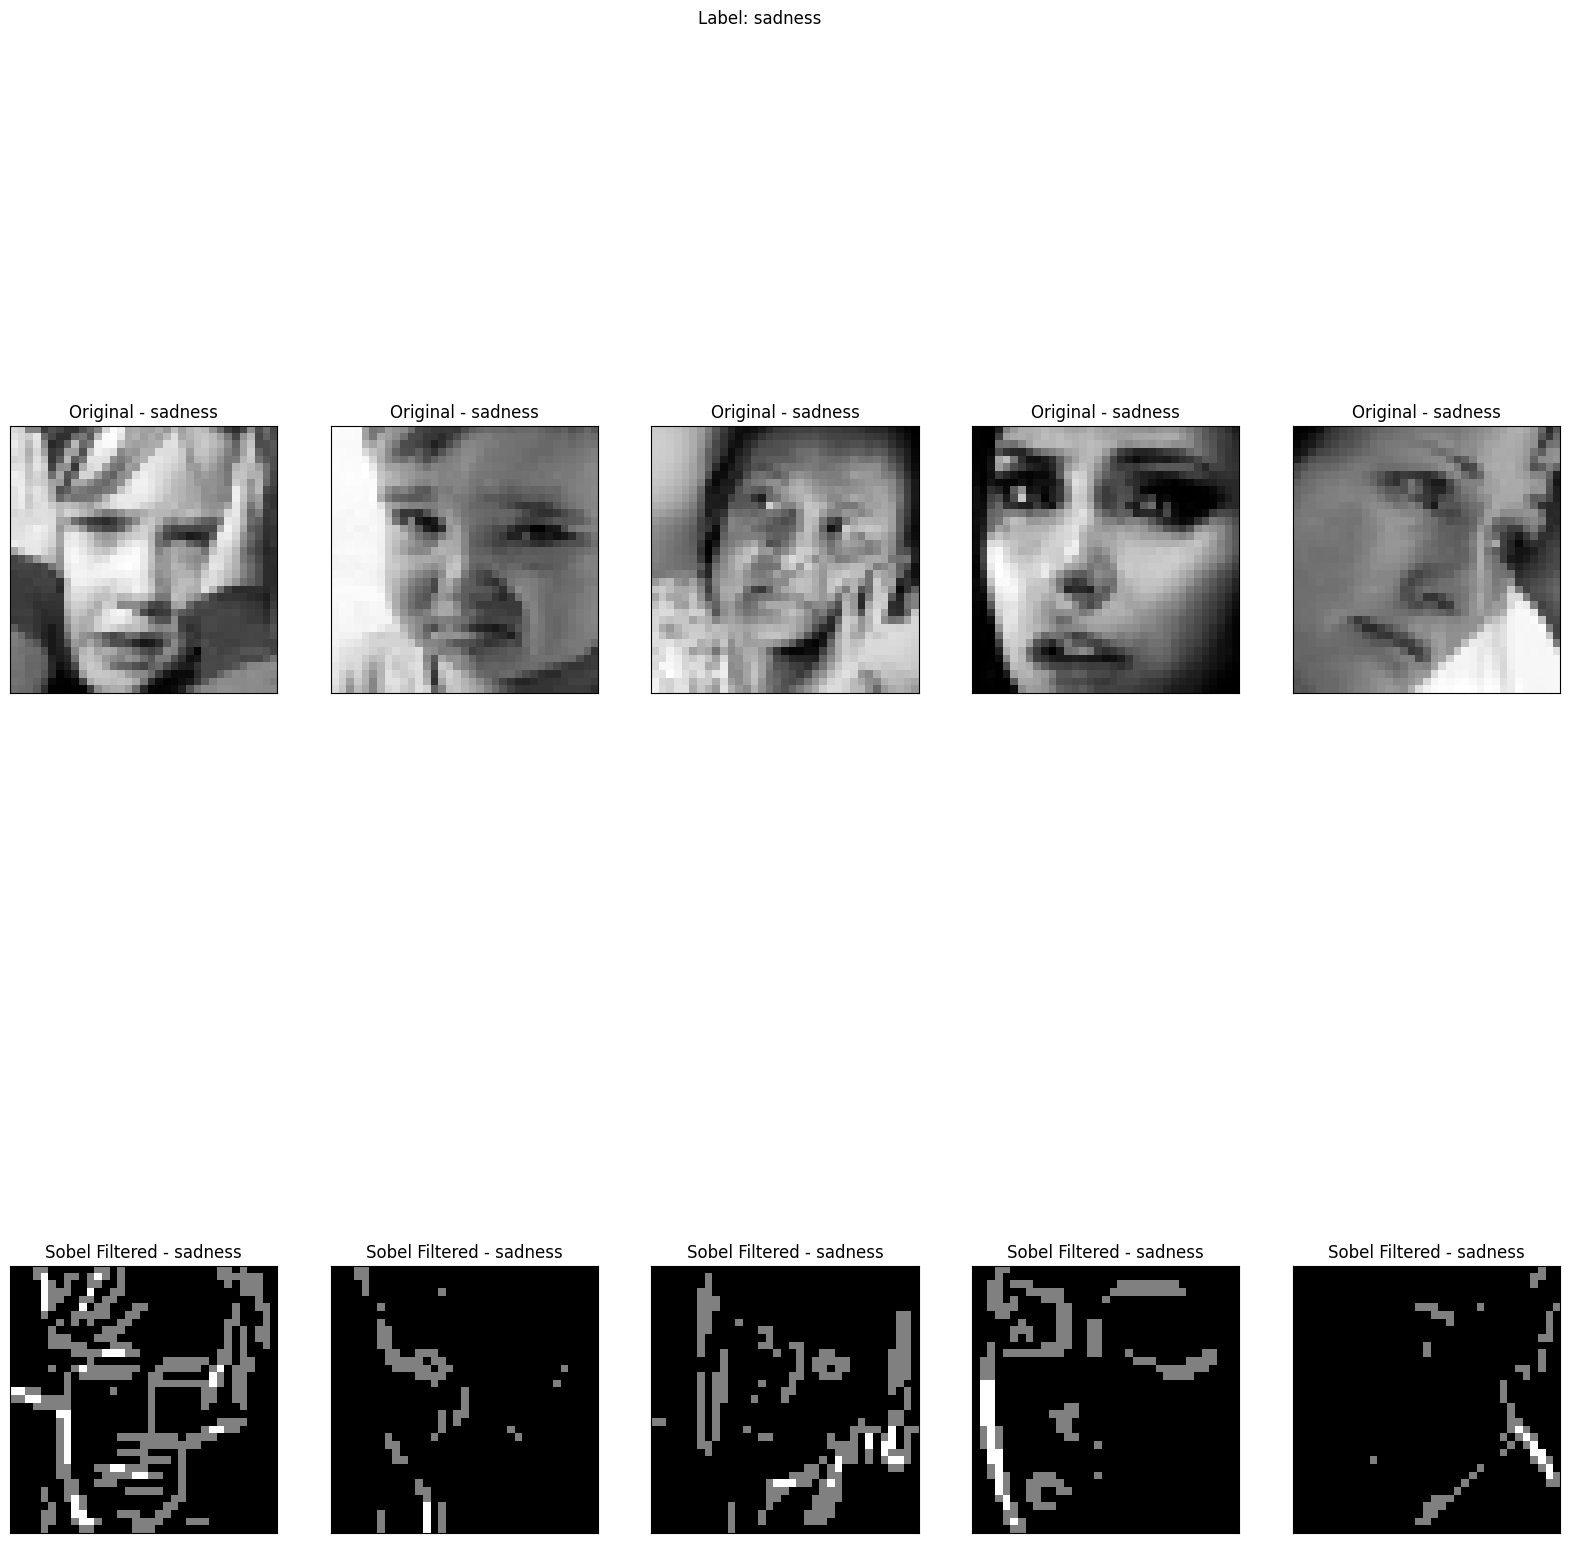

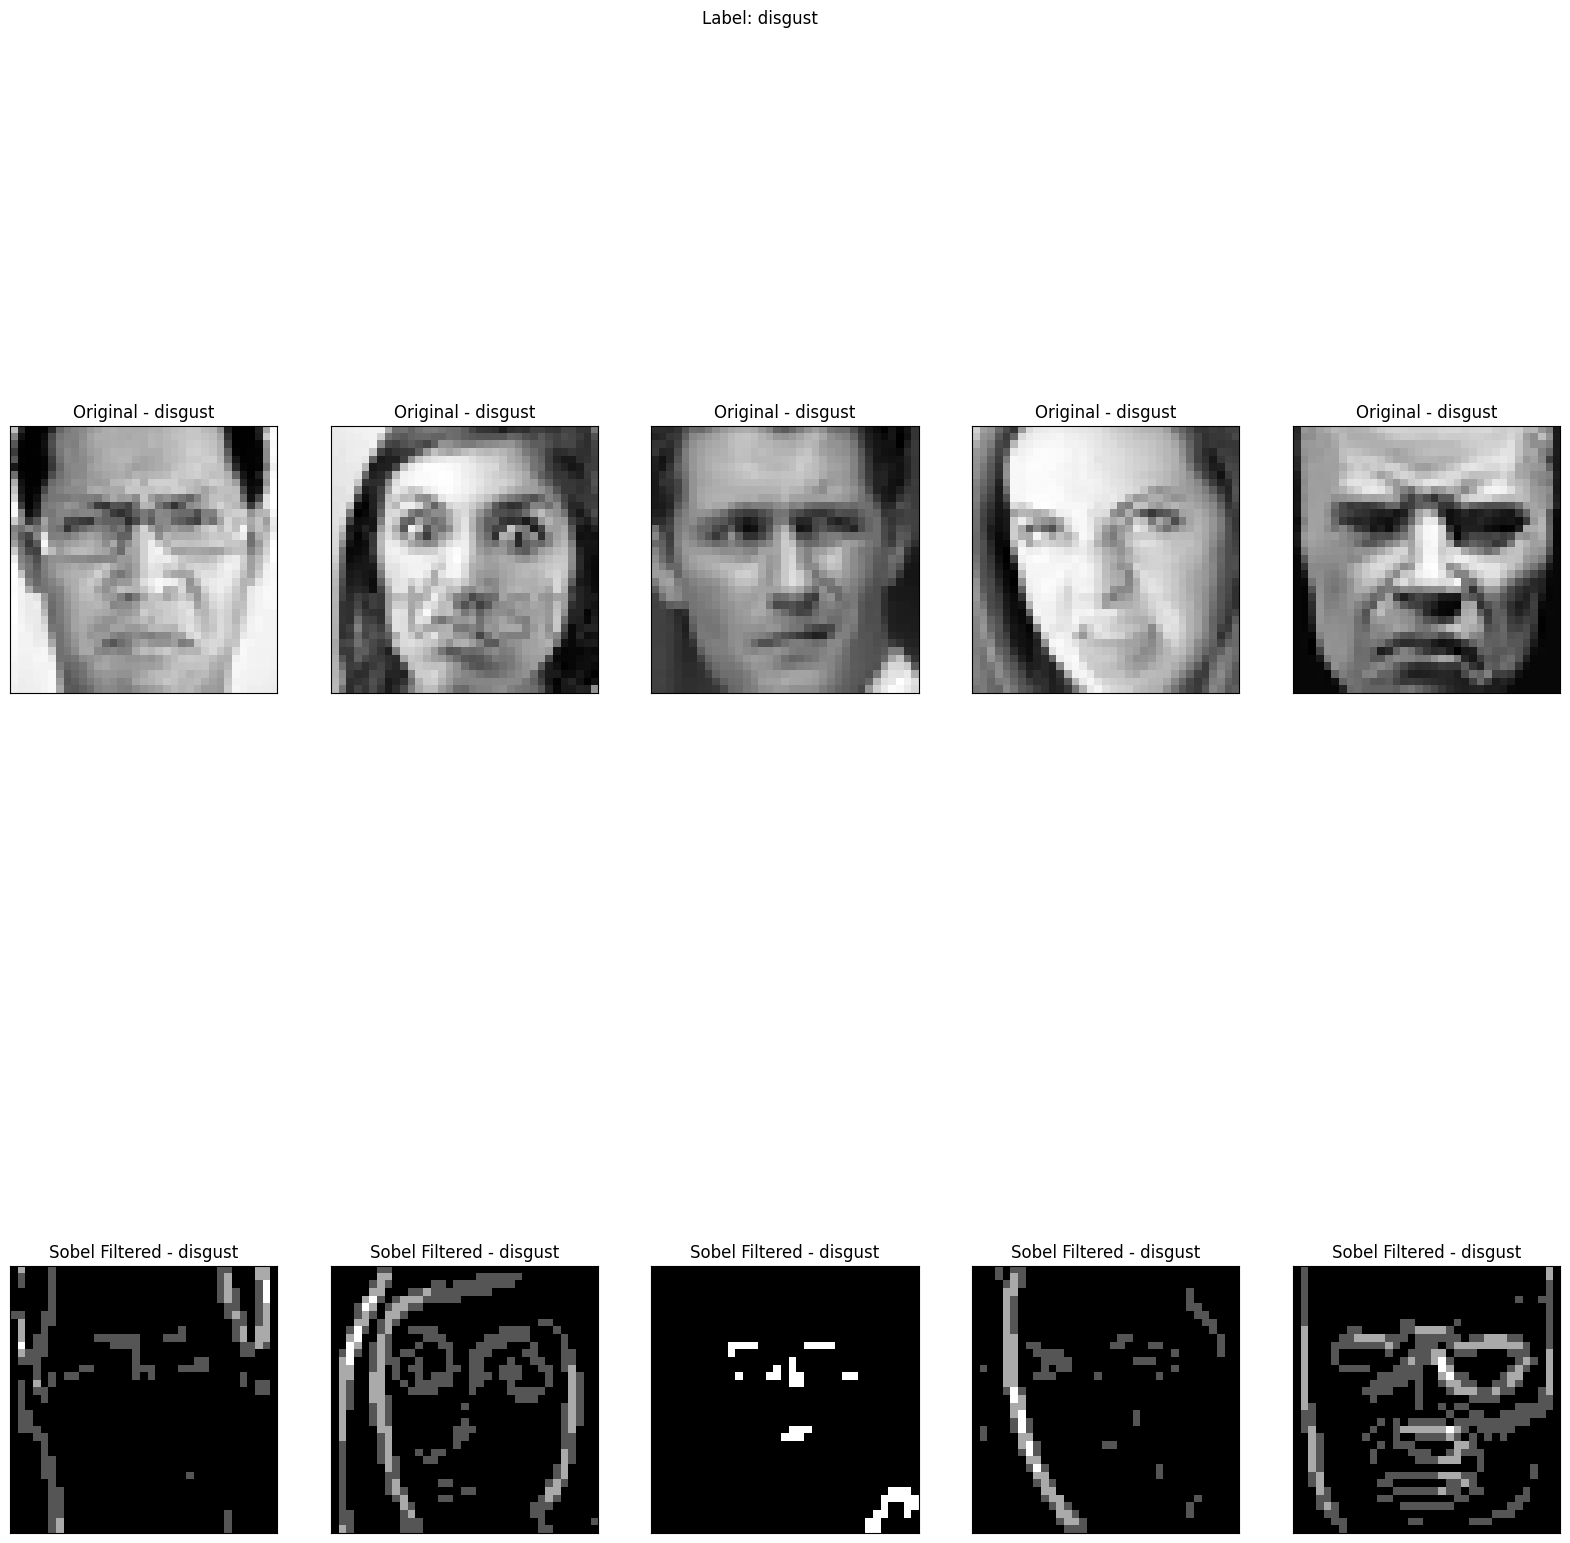

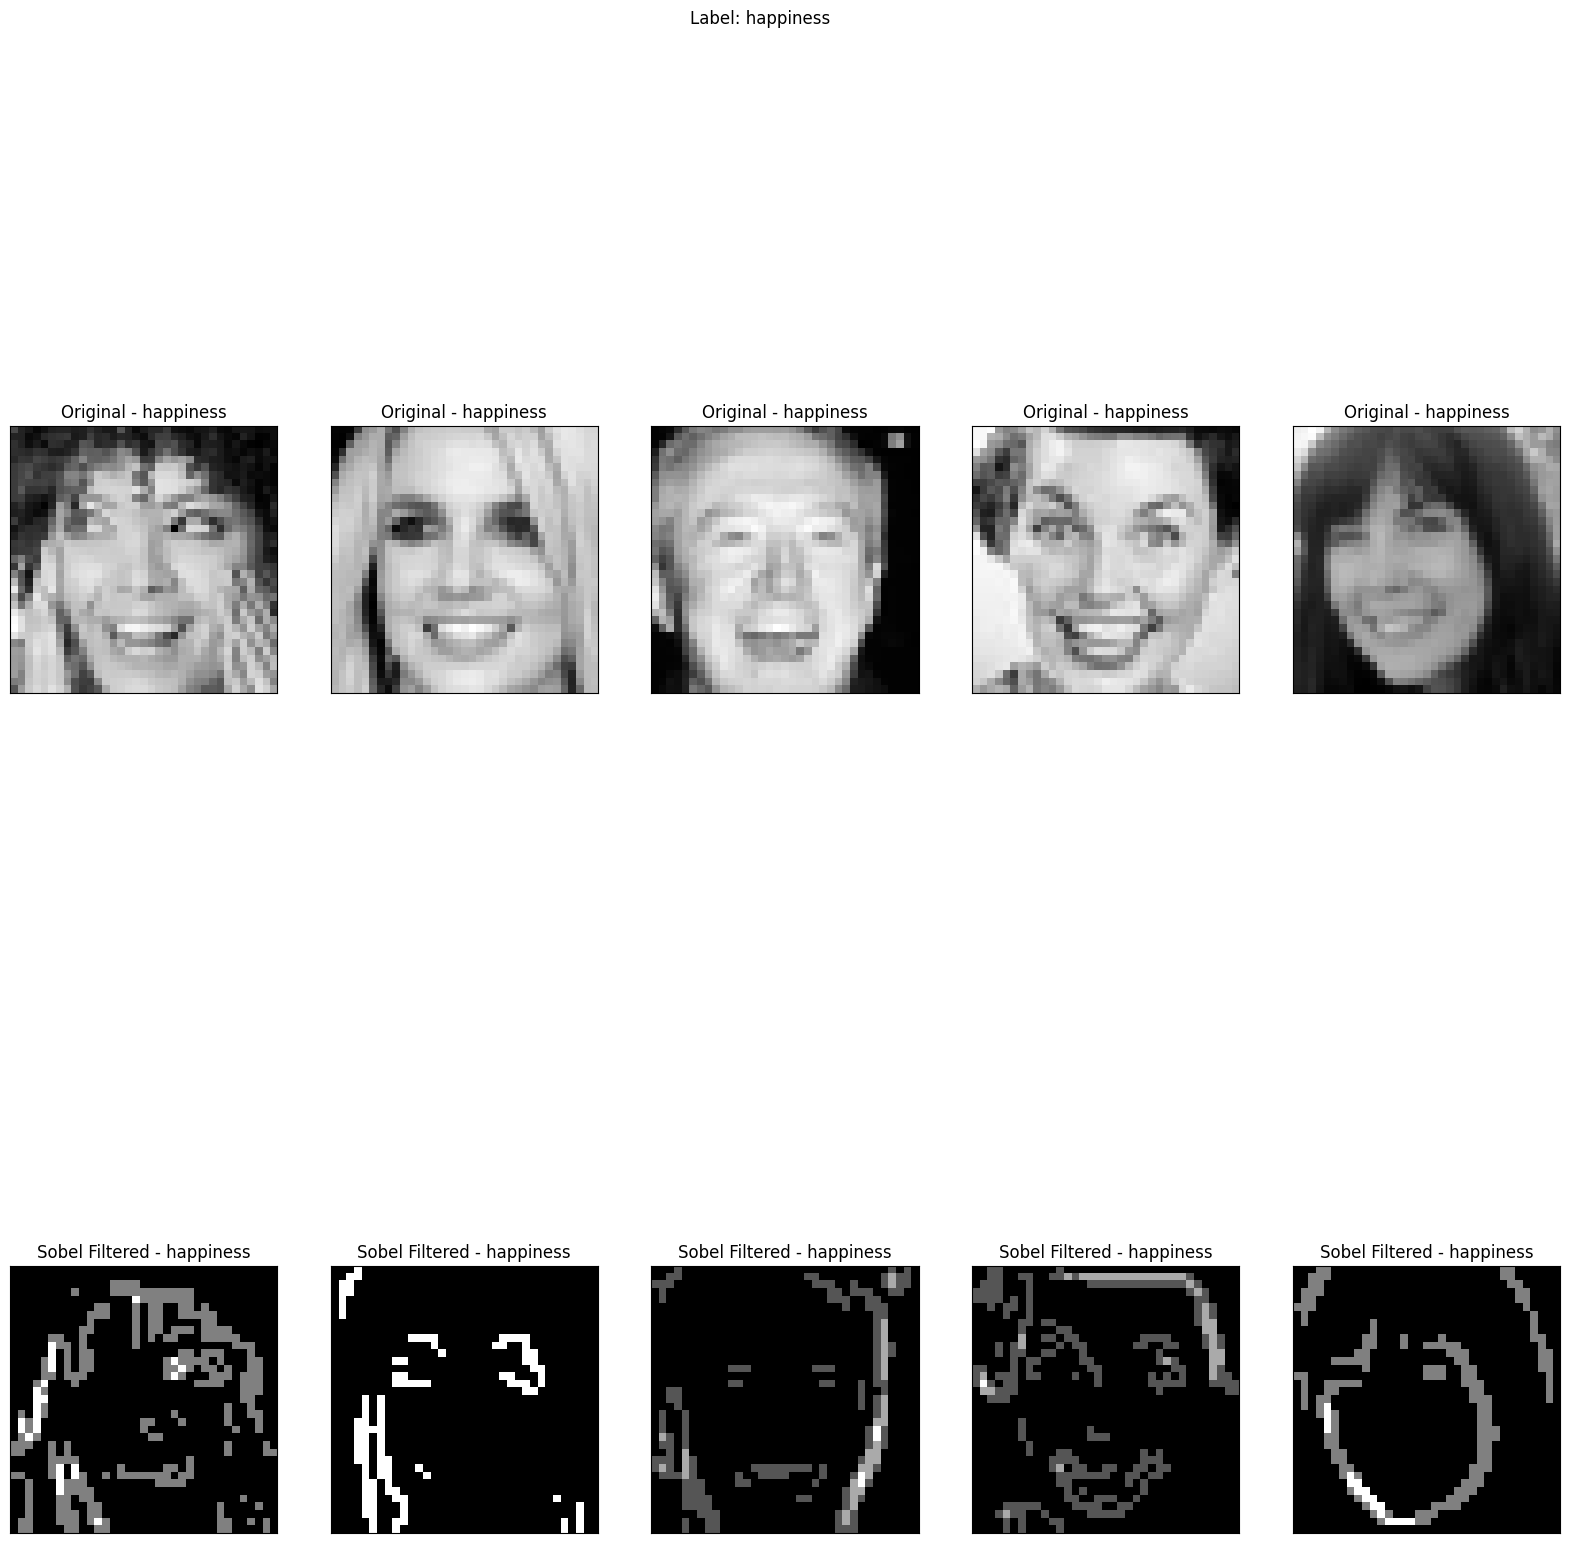

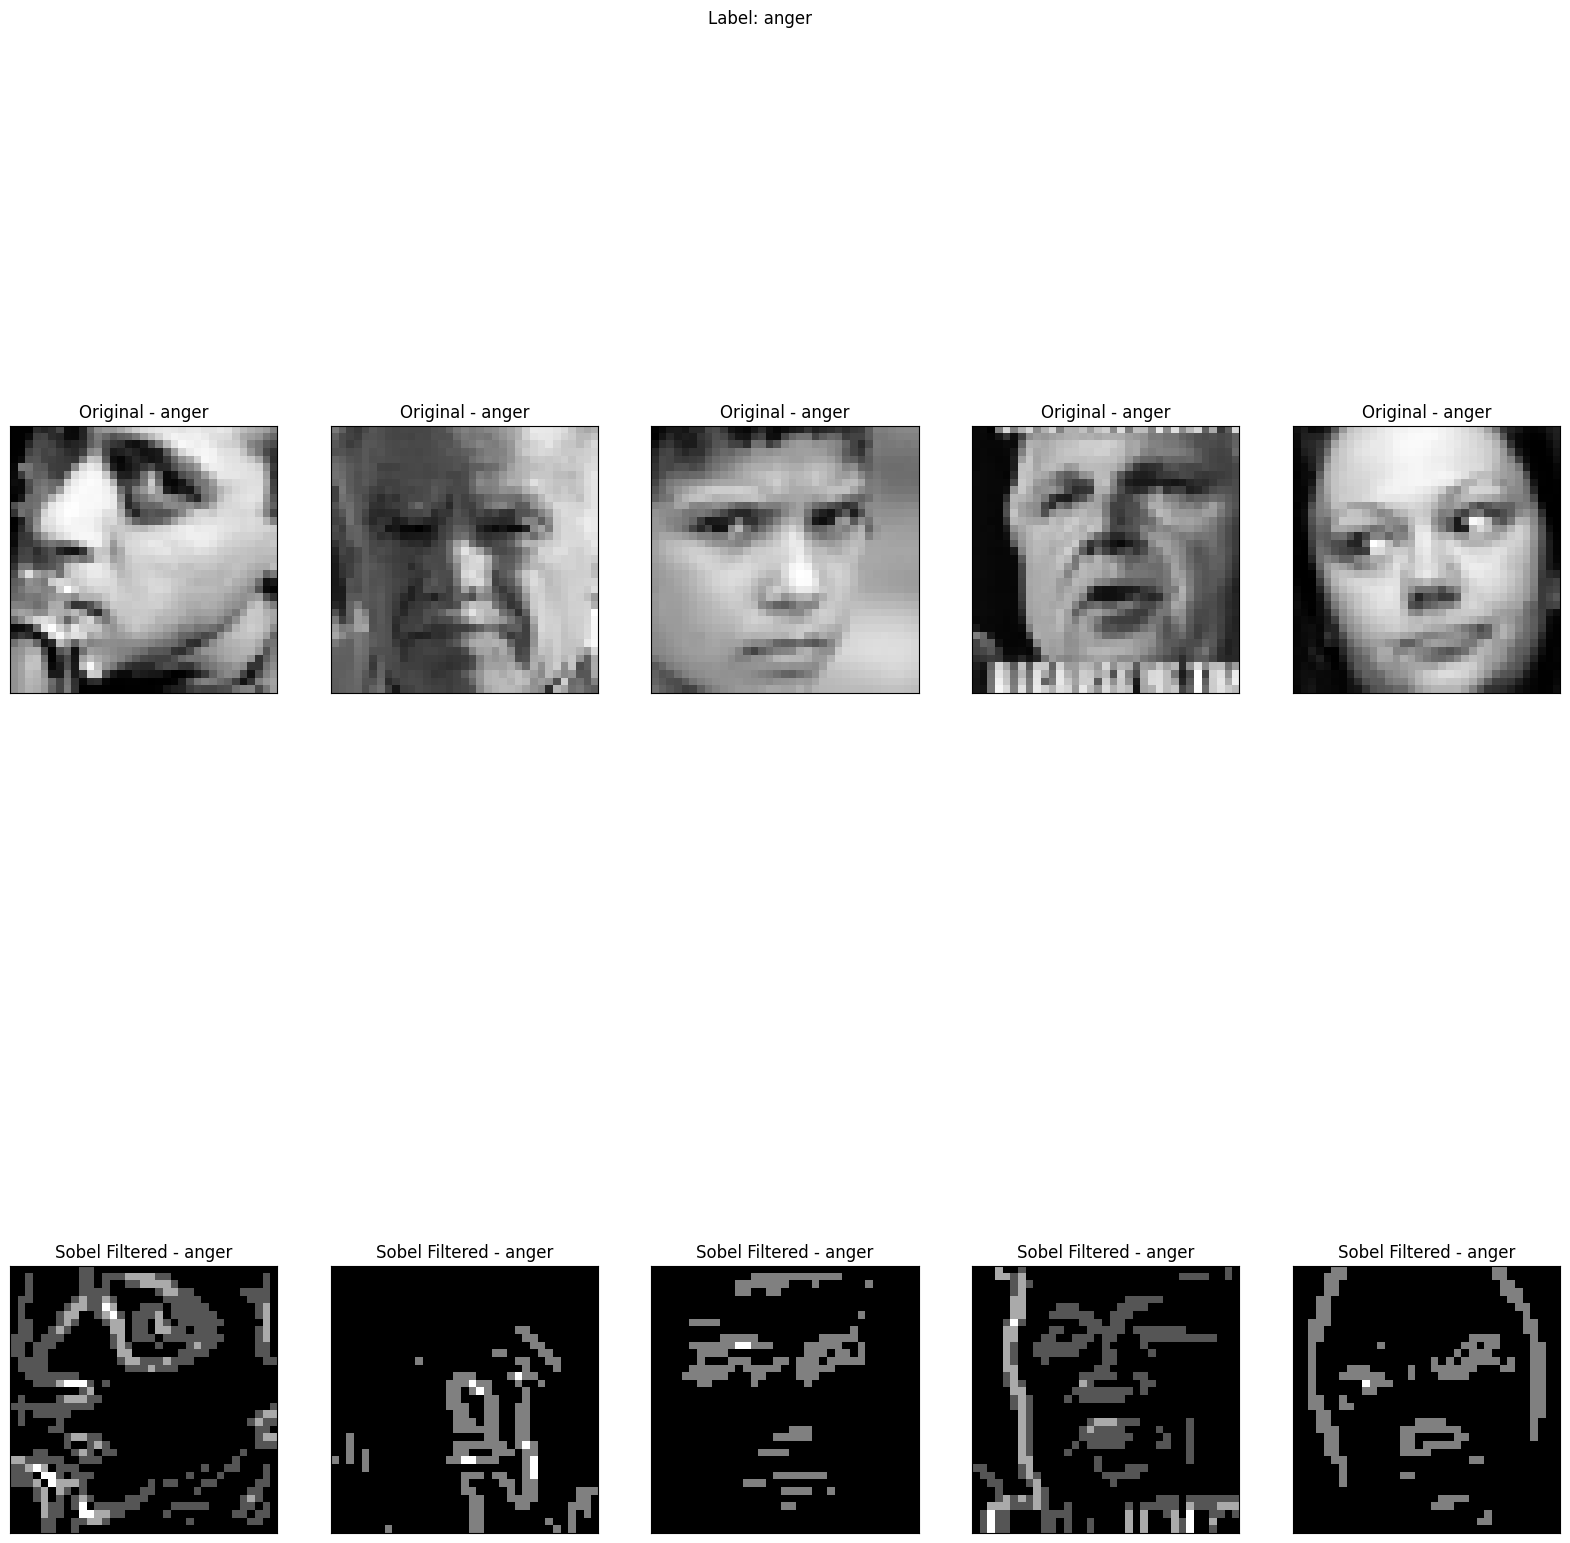

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_data(dir_path, img_size):
    labels = {}
    data = []
    labels_list = []
    class_count = 0

    # Iterate over directory
    for i, path in enumerate(os.listdir(dir_path)):
        if not path.startswith('.'):  # Ignore hidden files/folders
            class_path = os.path.join(dir_path, path)  # Use os.path.join for correct path
            labels[i] = path
            for file in os.listdir(class_path):
                if not file.startswith('.'):
                    img_path = os.path.join(class_path, file)  # Use os.path.join for correct path
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                    if img is None:
                        print(f"Warning: Could not load image at {img_path}. It may be corrupt or the path may be incorrect.")
                        continue
                    img = cv2.resize(img, img_size)  # Resize the image to the specified IMG_SIZE
                    data.append(img)
                    labels_list.append(class_count)
            class_count += 1

    data = np.array(data, dtype='float32') / 255.0  # Normalize the data
    labels_list = np.array(labels_list)
    return data, labels_list, labels

def display_labels(labels):
    print("Labels in the dataset:")
    for label in labels.values():
        print(label)

def apply_sobel_filter(img): #edge detection
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    return sobel.astype(np.uint8)

def plot_samples_with_sobel(X, y, labels_dict, n=5):
    for index, label in labels_dict.items():
        indices = np.where(y == index)[0]
        if len(indices) > n:
            indices = indices[:n]

        imgs = [X[i] for i in indices]
        sobel_imgs = [apply_sobel_filter(img) for img in imgs]
        num_imgs = len(imgs)

        plt.figure(figsize=(20, num_imgs * 4))  # Adjusted size for better visibility
        for idx in range(num_imgs):
            # Plot original image
            plt.subplot(2, num_imgs, idx + 1)
            plt.imshow(imgs[idx], cmap='gray')
            plt.title(f'Original - {label}')
            plt.xticks([])
            plt.yticks([])

            # Plot Sobel filtered image
            plt.subplot(2, num_imgs, idx + 1 + num_imgs)
            plt.imshow(sobel_imgs[idx], cmap='gray')
            plt.title(f'Sobel Filtered - {label}')
            plt.xticks([])
            plt.yticks([])

        plt.suptitle(f'Label: {label}')
        plt.show()

# Example usage
TRAIN_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train/'
TEST_DIR = '/kaggle/input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test/'
IMG_SIZE = (35, 35)  # Correctly define IMG_SIZE as a tuple

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

# Print all labels
display_labels(train_labels)

# Display some sample images with Sobel filter applied
plot_samples_with_sobel(X_train, y_train, train_labels, 5)
